# 2 Anomaly Detection Models

In this second part we will use the datasets cleaned and preprocessed in Notebook 1 to test different approaches to the anomaly detection problem.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
sns.set_theme()

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import HistGradientBoostingClassifier
from plot_decision_regions import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

From previous notebook we have saved several csv files. 

- sensors_scaled.csv can be used with Neural Networks or Classical Classification algorithms like XGBoost
- pump_data_cleaned. csv can be used with algorithms like HGB Classifier which supports multioutput
- sensorsdf_red_pca_0p55.csv can be used with PCA plus other classification algorithms. It contains the columns without the target downsized from 49 columns to 2 PCA components which explain the 55% of the variance in the sensors dataset.


In [5]:
sensors_scaled = pd.read_csv('sensors_scaled.csv')
sensors_scaled.drop(columns='Unnamed: 0',inplace=True)
sensors_scaled.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_01       220320 non-null  float64
 1   sensor_02       220320 non-null  float64
 2   sensor_03       220320 non-null  float64
 3   sensor_04       220320 non-null  float64
 4   sensor_05       220320 non-null  float64
 5   sensor_10       220320 non-null  float64
 6   sensor_11       220320 non-null  float64
 7   sensor_12       220320 non-null  float64
 8   sensor_13       220320 non-null  float64
 9   sensor_14       220320 non-null  float64
 10  sensor_16       220320 non-null  float64
 11  sensor_17       220320 non-null  float64
 12  sensor_18       220320 non-null  float64
 13  sensor_19       220320 non-null  float64
 14  sensor_20       220320 non-null  float64
 15  sensor_21       220320 non-null  float64
 16  sensor_22       220320 non-null  float64
 17  sensor_23 

In [6]:
sensors_scaled.target_one_hot.value_counts()
''' 
NORMAL        205836
RECOVERING     14477
BROKEN             7
'''

' \nNORMAL        205836\nRECOVERING     14477\nBROKEN             7\n'

In [7]:
sensorsdf_red_pca_0p55 = pd.read_csv('sensorsdf_red_pca_0p55.csv')
sensorsdf_red_pca_0p55.drop(columns='Unnamed: 0',inplace=True)
sensorsdf_red_pca_0p55.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pc1     220320 non-null  float64
 1   pc2     220320 non-null  float64
dtypes: float64(2)
memory usage: 3.4 MB


## PCA Pre-Analysis

PCA is an unsupervised technique which does not use any class label information. PCA needs as input standarized data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sensors_scaled.iloc[:,1:-1], sensors_scaled.iloc[:,-1:], test_size = 0.3, \
                                                          random_state = 42)


In [9]:
X_train

sensor_02  sensor_03  sensor_04  sensor_05  sensor_10  sensor_11  \
167988   0.165900   1.273005   0.116191  -0.101778   0.162330   0.705502   
2788     0.236924  -0.395797   0.314694   0.401916  -0.236982   0.801334   
71794   -0.082678  -0.503461   0.303443   0.211149   0.039129  -0.085660   
192675   0.568365   0.519352   0.283351   0.015371   0.321706   0.542929   
177154  -0.082678   0.232247   0.255223  -0.489443   0.249906   0.248635   
...           ...        ...        ...        ...        ...        ...   
119879  -0.260238  -0.754679   0.343626   0.286593   0.357556  -0.123040   
103694  -0.212889  -1.400666   0.260849   0.009952   0.804241  -0.290794   
131932  -3.681177  -3.661623  -4.078242   1.537998  -3.410989  -3.208037   
146867  -0.366771   0.232247   0.319516   0.370699   0.618388   0.840202   
121958   0.651225  -0.018969  -0.039719   1.473392  -0.400887  -0.565836   

        sensor_12  sensor_13  sensor_14  sensor_16  ...  sensor_40  sensor_41  \
167988   0.212564   0.729361   0.386735   0.378690  ...  -0.272520   0.138413   
2788     0.518838  -0.789901   0.384608   0.383919  ...  -0.333451  -0.521023   
71794   -0.414815  -0.150072   0.395809   0.372779  ...  -1.003693  -0.455080   
192675   0.543345  -0.120305   0.372910   0.358745  ...   1.762576  -0.158334   
177154   0.472101   0.217874   0.386980   0.390081  ...   0.665818  -0.455080   
...           ...        ...        ...        ...  ...        ...        ...   
119879   0.174626  -0.906354   0.394538   0.378748  ...  -0.065355   0.006525   
103694  -0.429707  -0.931418   0.378321   0.380656  ...   0.202742   1.457285   
131932  -2.881005  -1.025707   0.423965   0.399034  ...  -1.893286  -1.279374   
146867   0.684005  -0.745827   0.393521   0.374108  ...   0.019949   0.303271   
121958   0.008766  -0.955872   0.398365   0.359396  ...  -0.004424   0.797848   

        sensor_42  sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  \
167988   0.326413   0.011846   0.189421   0.023978   0.074885   0.630643   
2788    -0.409739  -0.271121  -0.010553   5.253484   2.220934  -0.450087   
71794   -0.308201  -0.695571  -0.635469  -0.043645   0.204388  -0.450087   
192675  -0.054355   0.601360   0.089434  -0.314137   0.019384  -0.228398   
177154  -0.282816  -0.035315  -0.060546   2.864141   1.924927   0.492088   
...           ...        ...        ...        ...        ...        ...   
119879  -0.105124  -0.176799  -0.535483  -0.629711  -0.461627  -0.394664   
103694   0.326413   0.035426   0.039441  -0.426842  -0.406125   3.235475   
131932  -0.688969  -1.214343  -0.960426  -0.877662  -1.016639  -1.087439   
146867  -0.105124  -0.223959   0.539374  -0.088727  -0.498627   3.207764   
121958   0.199490  -0.294701  -0.410500  -0.223973  -0.350624  -0.089843   

        sensor_48  sensor_49  
167988   0.670351   0.069432  
2788     1.039783   0.658948  
71794   -0.536459  -0.565430  
192675   0.642204   0.401979  
177154   2.003823   0.281053  
...           ...        ...  
119879  -1.071255  -0.610777  
103694  -0.673676  -0.247999  
131932  -1.447723  -1.321218  
146867  -0.072030   1.324042  
121958  -0.631455  -0.474735  

[154224 rows x 43 columns]

In [10]:
# Initialize PCA estimator

pca = PCA(n_components = 2)

# Dimensionality Reduction

X_sensors_train_pca = pca.fit_transform(X_train)
X_sensors_test_pca = pca.transform(X_test)


In [11]:
pca_explained = PCA(n_components= None)
X_sensors_train_pca = pca_explained.fit_transform(X_train)
pca_explained.explained_variance_ratio_

array([4.09067593e-01, 1.63394971e-01, 8.71729572e-02, 5.86446515e-02,
       4.20257478e-02, 2.93865580e-02, 2.54317959e-02, 2.11208564e-02,
       1.94506186e-02, 1.81583386e-02, 1.47784405e-02, 1.03551696e-02,
       9.92142432e-03, 8.57081585e-03, 8.14211745e-03, 7.47591479e-03,
       6.47236317e-03, 6.10204592e-03, 5.78227766e-03, 5.45462296e-03,
       5.04774051e-03, 4.71972871e-03, 4.57361086e-03, 4.57183462e-03,
       3.56205458e-03, 3.21753542e-03, 2.75013839e-03, 2.49244021e-03,
       2.38310555e-03, 2.05878846e-03, 1.69145012e-03, 1.38021019e-03,
       1.10151965e-03, 1.03048898e-03, 9.26820487e-04, 4.50740315e-04,
       3.42969820e-04, 2.31281646e-04, 2.09710163e-04, 1.49950162e-04,
       1.31156847e-04, 3.86581304e-05, 2.87864051e-05])

In [12]:
pca_explained.explained_variance_ratio_.shape

(43,)

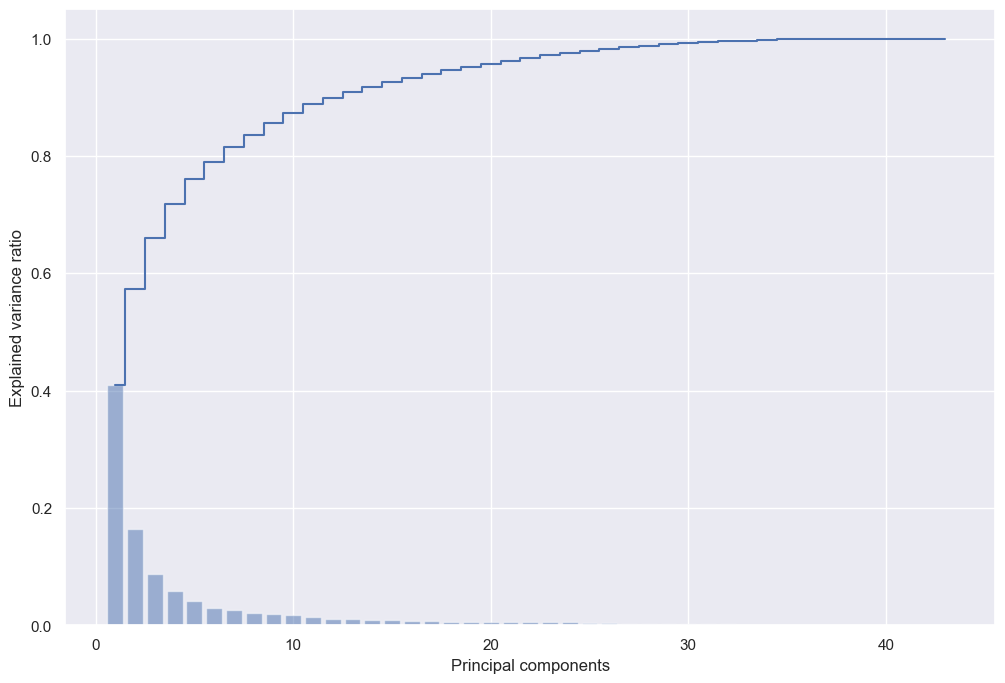

In [13]:
plt.bar(range(1, 44), pca_explained.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 44), np.cumsum(pca_explained.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [14]:
# Assessing Feature Importance

sklearn_loadings = pca_explained.components_.T * np.sqrt(pca_explained.explained_variance_)
sklearn_loadings

array([[ 1.42967450e-01,  7.78985249e-01, -1.15157915e-01, ...,
        -2.02611086e-03,  1.44027854e-04,  3.13714579e-05],
       [ 8.56709099e-02,  7.73321005e-01, -1.04639987e-01, ...,
         7.65263083e-04, -3.29343067e-05,  1.50798002e-05],
       [ 7.98570890e-02,  8.23830915e-01, -2.12451085e-01, ...,
        -1.09055598e-03,  2.44985316e-04,  4.97556252e-05],
       ...,
       [-7.68659718e-02,  4.66310091e-01,  2.49408234e-01, ...,
         3.53997205e-04, -6.77297923e-05,  1.48768992e-05],
       [-2.21292542e-01,  6.53991135e-01, -2.53946920e-01, ...,
         5.89744701e-04,  1.02985327e-05,  6.18127266e-05],
       [-1.00048984e-01,  5.56098739e-01, -6.76599137e-02, ...,
        -2.63062675e-04,  4.79483274e-05,  2.95845849e-05]])

In [15]:
sklearn_loadings[:,1]

array([ 0.77898525,  0.77332101,  0.82383092,  0.27726956,  0.8094325 ,
        0.85537906,  0.79708018,  0.49602635, -0.0132669 , -0.01621918,
       -0.02510771, -0.01893655, -0.01115827, -0.00892761, -0.00783579,
        0.01851745,  0.03536379, -0.02238888, -0.00733207,  0.00396464,
        0.0770568 , -0.24199274, -0.10181638,  0.0034923 , -0.12046222,
       -0.06453916, -0.07392956,  0.1150977 ,  0.08544318,  0.15081162,
       -0.2617316 ,  0.48455125,  0.16958035,  0.61642193,  0.28882289,
        0.19139734,  0.39401254,  0.51746169,  0.43945316,  0.47778254,
        0.46631009,  0.65399114,  0.55609874])

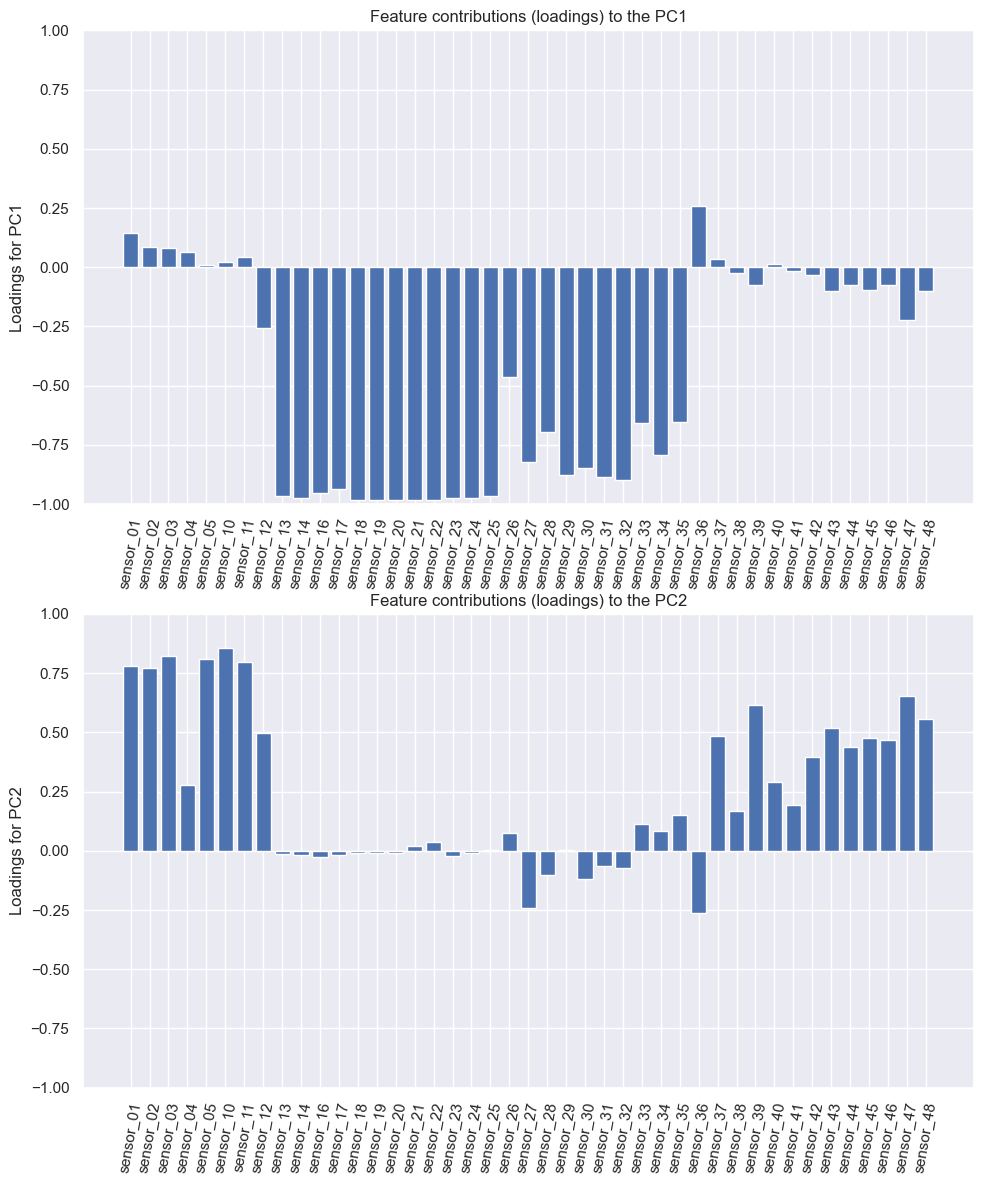

In [16]:
# Assessing Feature Importance

sklearn_loadings = pca_explained.components_.T * np.sqrt(pca_explained.explained_variance_)

fig,ax = plt.subplots(2,1, figsize = (10,12))
# Change 0 to see another PC
#PC1
pc_num = 0 
ax[0].bar(range(43), sklearn_loadings[:,pc_num], align = 'center')
ax[0].set_ylabel('Loadings for PC' + str(pc_num +1))
ax[0].set_xticks(range(43))
ax[0].set_xticklabels(sensors_scaled.columns[0:43], rotation =80)
ax[0].set_ylim([-1,1])
ax[0].set_title('Feature contributions (loadings) to the PC' + str(pc_num +1))


# PC2
pc_num = 1 
ax[1].bar(range(43), sklearn_loadings[:,pc_num], align = 'center')
ax[1].set_ylabel('Loadings for PC' + str(pc_num +1))
ax[1].set_xticks(range(43))
ax[1].set_xticklabels(sensors_scaled.columns[0:43], rotation =80)
ax[1].set_ylim([-1,1])
plt.tight_layout()
plt.grid(True)
ax[1].set_title('Feature contributions (loadings) to the PC' + str(pc_num +1))
plt.show()

## K-Means Clustering

In [17]:


km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

pipe_kmeans = make_pipeline(
                            km)


y_pred = pipe_kmeans.fit_predict(sensorsdf_red_pca_0p55.values)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

Find the optimal number of clusters

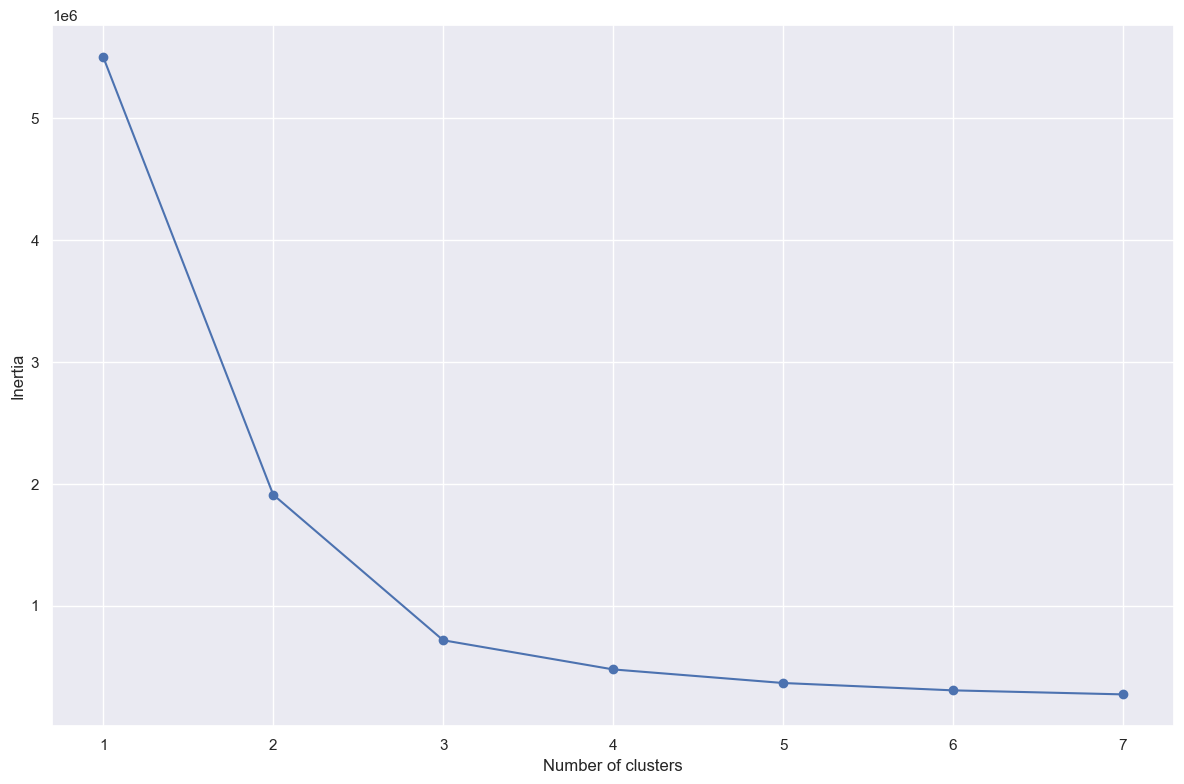

In [18]:
inertias = []

for i in range(1,8):
    km = KMeans(n_clusters=i, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
    km.fit(sensorsdf_red_pca_0p55.values)
    inertias.append(km.inertia_)
    
plt.plot(range(1,8), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.tight_layout()
plt.show()


So the ideal number of clusters is 3

In [19]:
sensors_scaled.values[:,-1:]

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

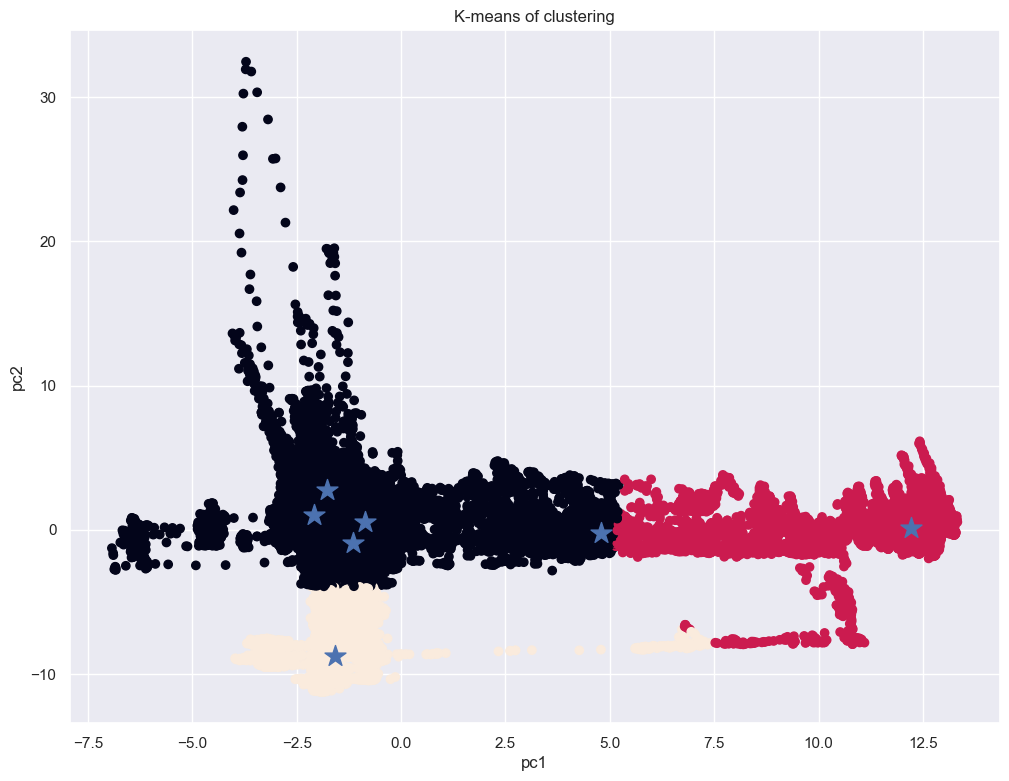

In [40]:
# plotting the clusters
_ = plt.figure(figsize=(12,9))
_ = plt.scatter(sensorsdf_red_pca_0p55['pc1'], sensorsdf_red_pca_0p55['pc2'], c=y_pred)
_ = plt.xlabel('pc1')
_ = plt.ylabel('pc2')
_ = plt.title('K-means of clustering')

plt.scatter(km.cluster_centers_[:,0],
            km.cluster_centers_[:,1],
            s=250, marker = '*', label = 'Centroids')
plt.show()


In [21]:
# Write a function that calculates distance between each point and 
# the centroid of the closest cluster

def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [22]:
# Assume that 13% of the entire data set are anomalies 
outliers_fraction = 0.13

# get the distance between each point and its nearest centroid. 
# the biggest distances are considered as anomaly
distance = getDistanceByPoint(sensorsdf_red_pca_0p55, km)

# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))

# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contains the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
sensorsdf_red_pca_0p55['kmeans_anomaly'] = (distance >= threshold).astype(int)

sensorsdf_red_pca_0p55.head()

pc1       pc2  kmeans_anomaly
0 -0.052115  0.379152               0
1 -0.052115  0.379152               0
2 -0.192002  0.427891               0
3 -0.193824  0.406918               0
4 -0.149628  0.547579               0

In [23]:
sensorsdf_red_pca_0p55["kmeans_anomaly"].value_counts()

0    191679
1     28641
Name: kmeans_anomaly, dtype: int64

In [24]:
pump_data = pd.read_csv('pump_data_cleaned.csv')

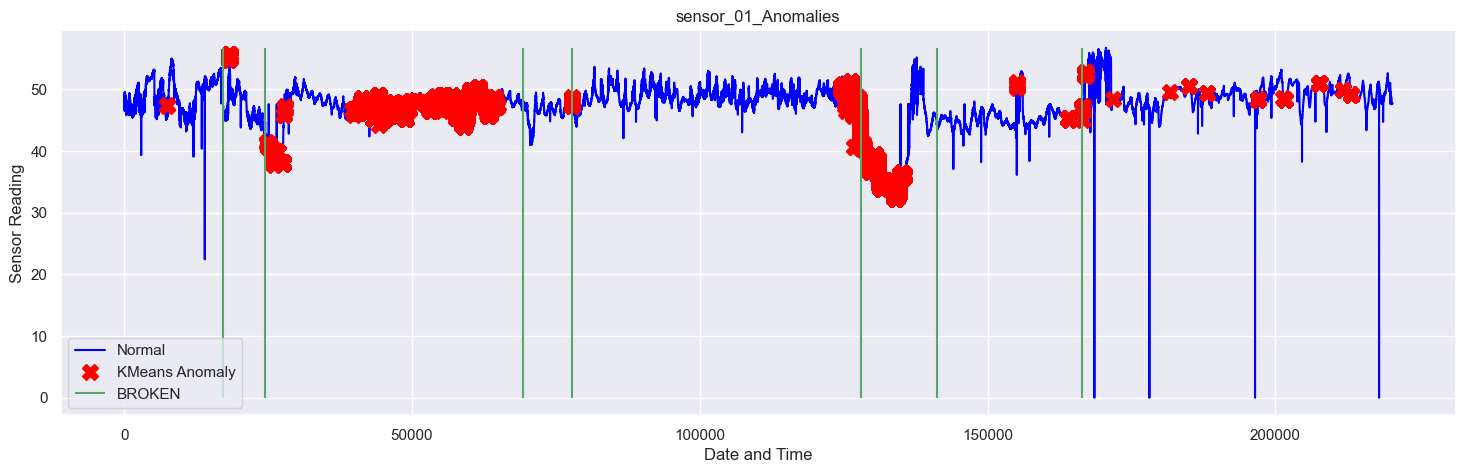

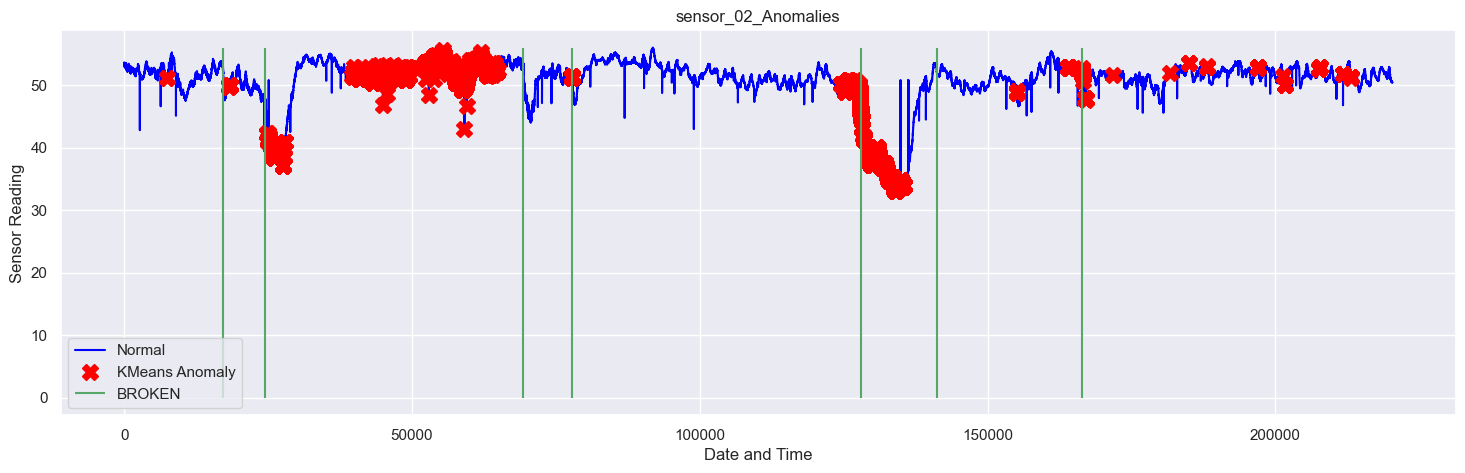

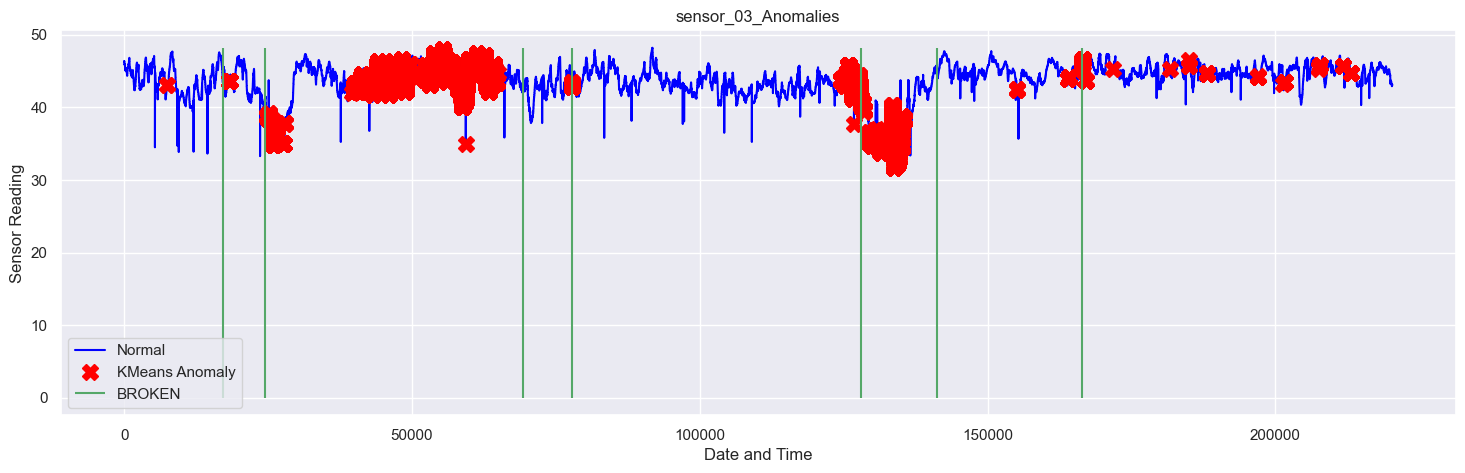

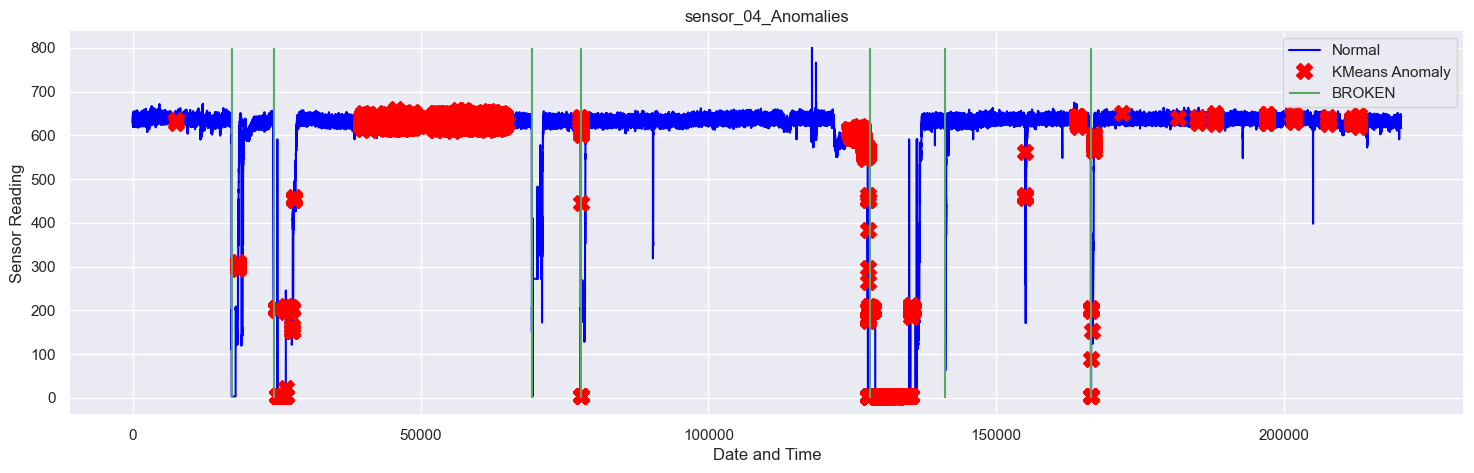

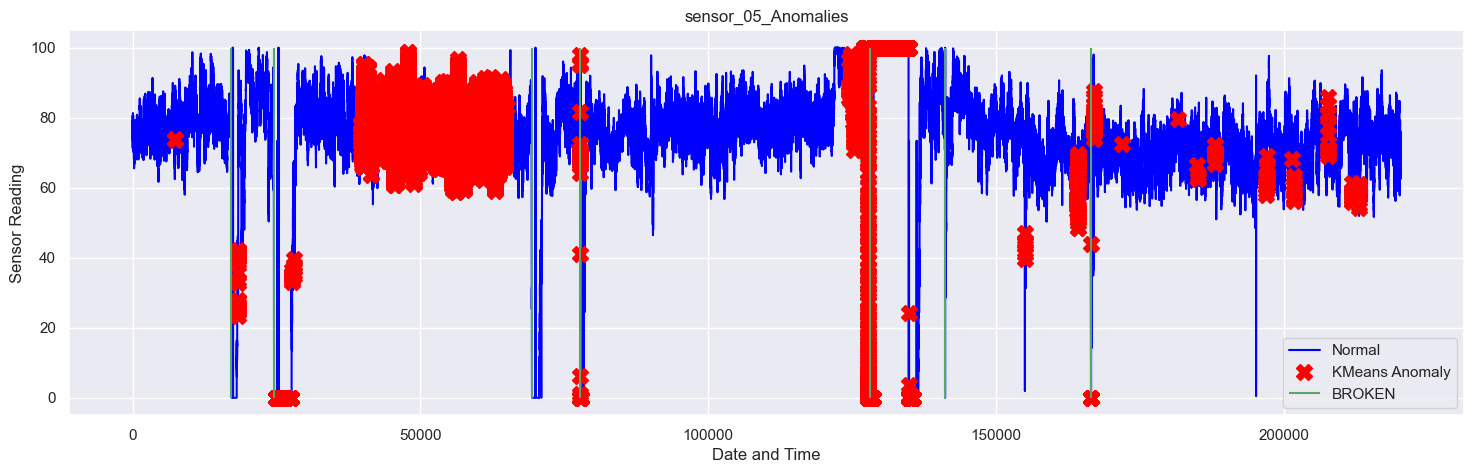

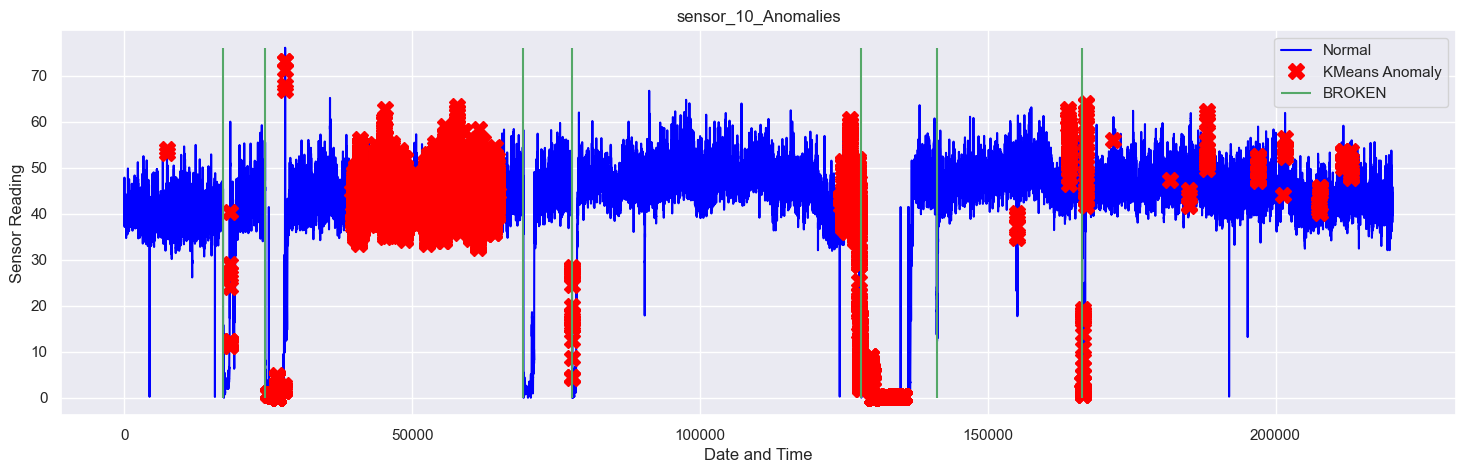

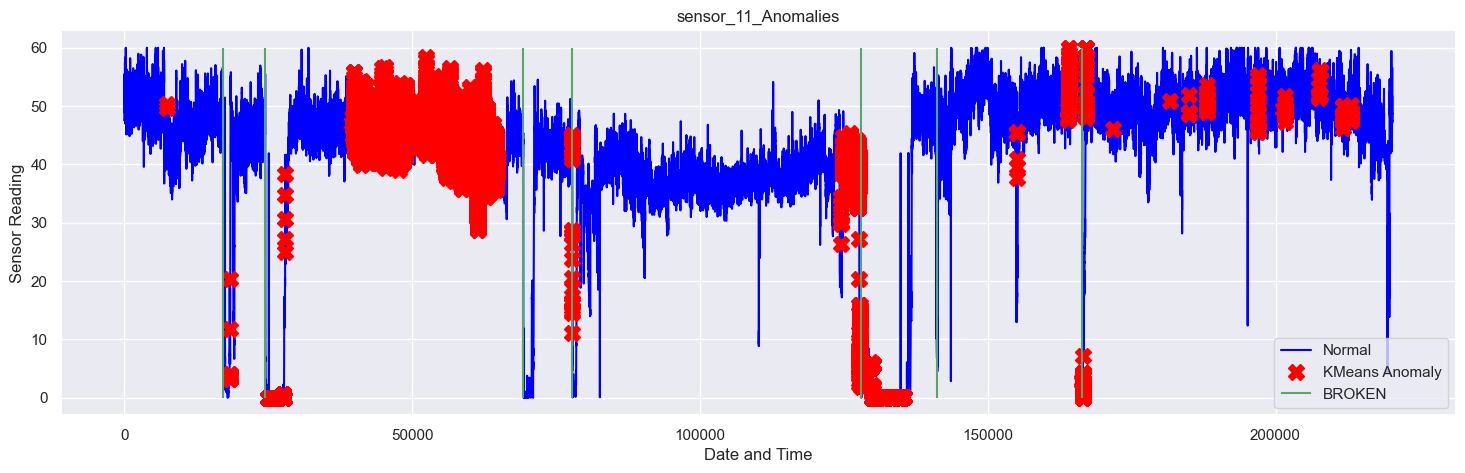

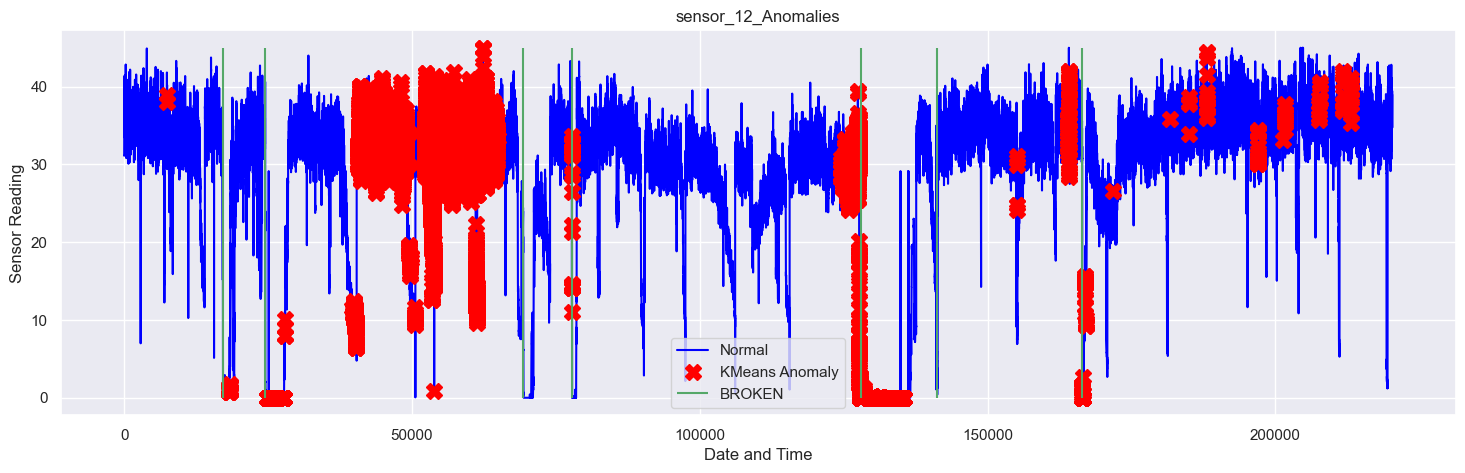

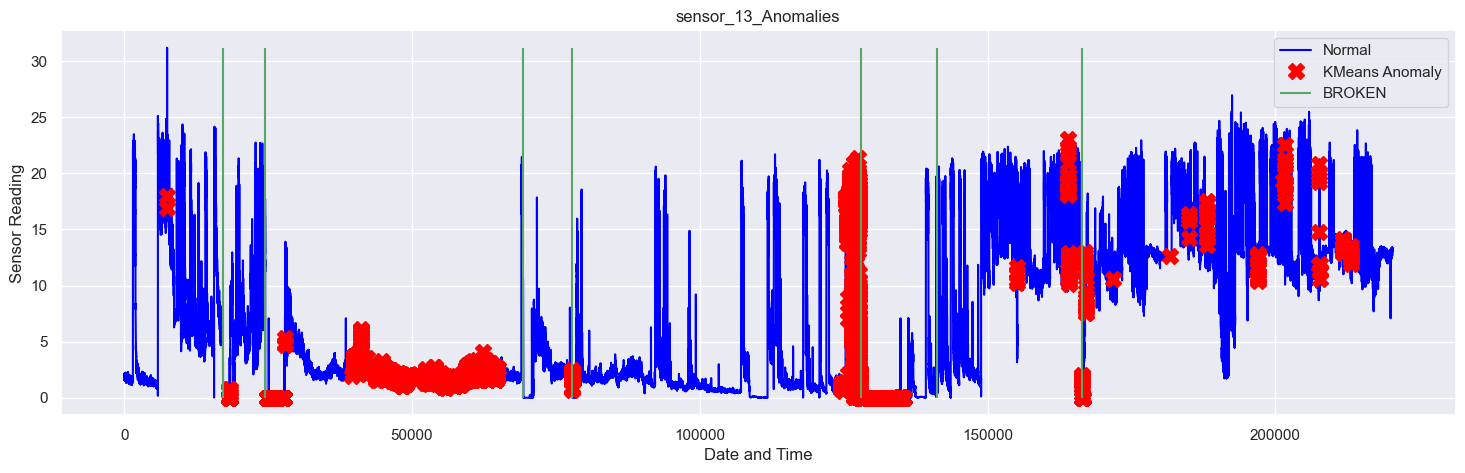

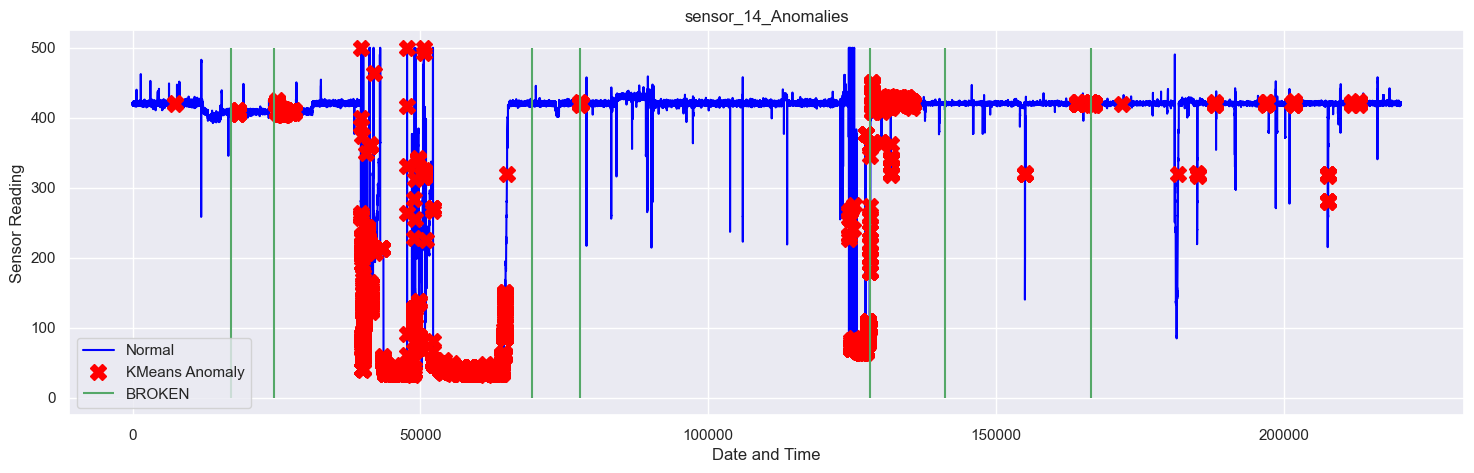

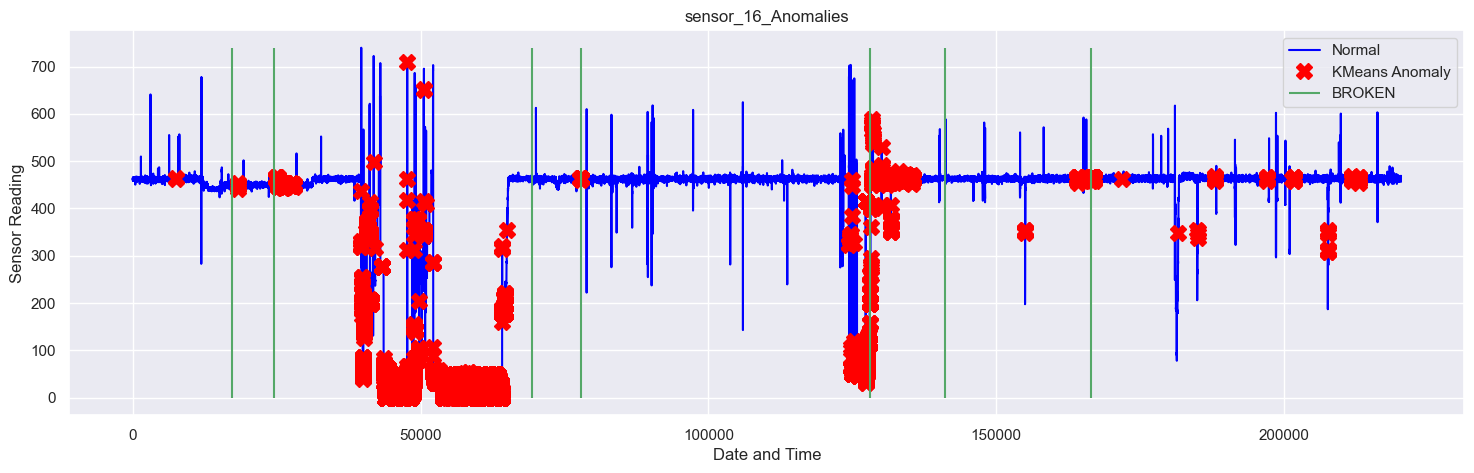

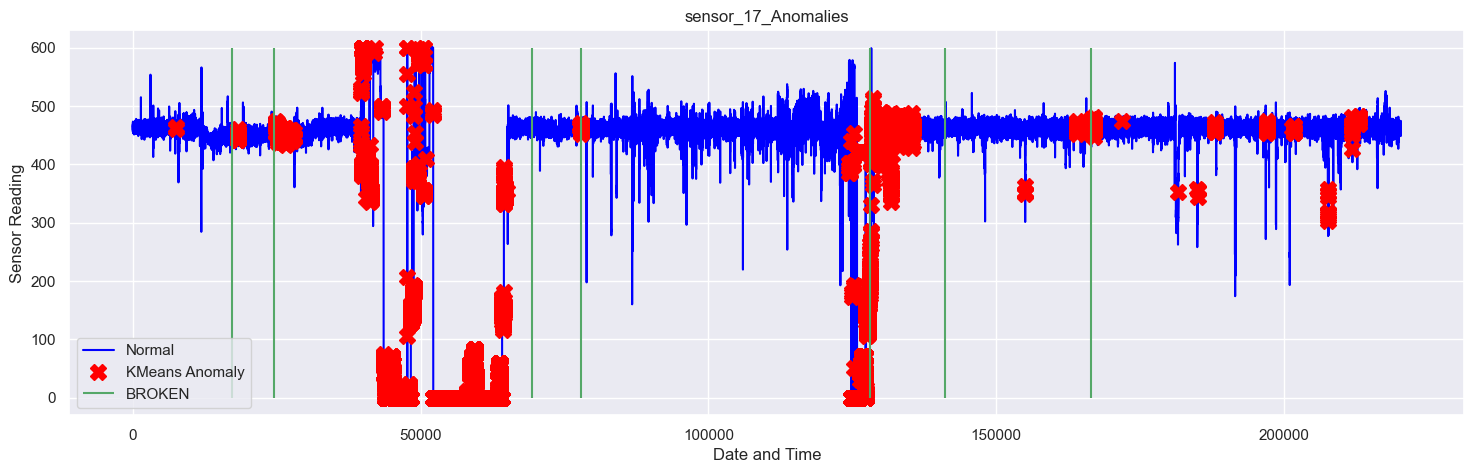

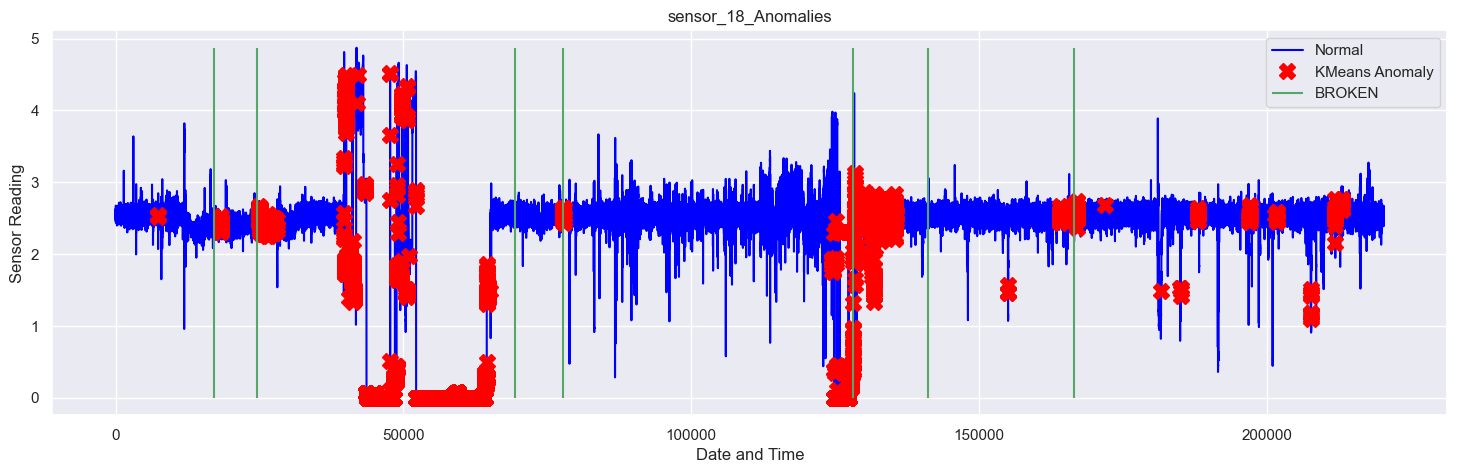

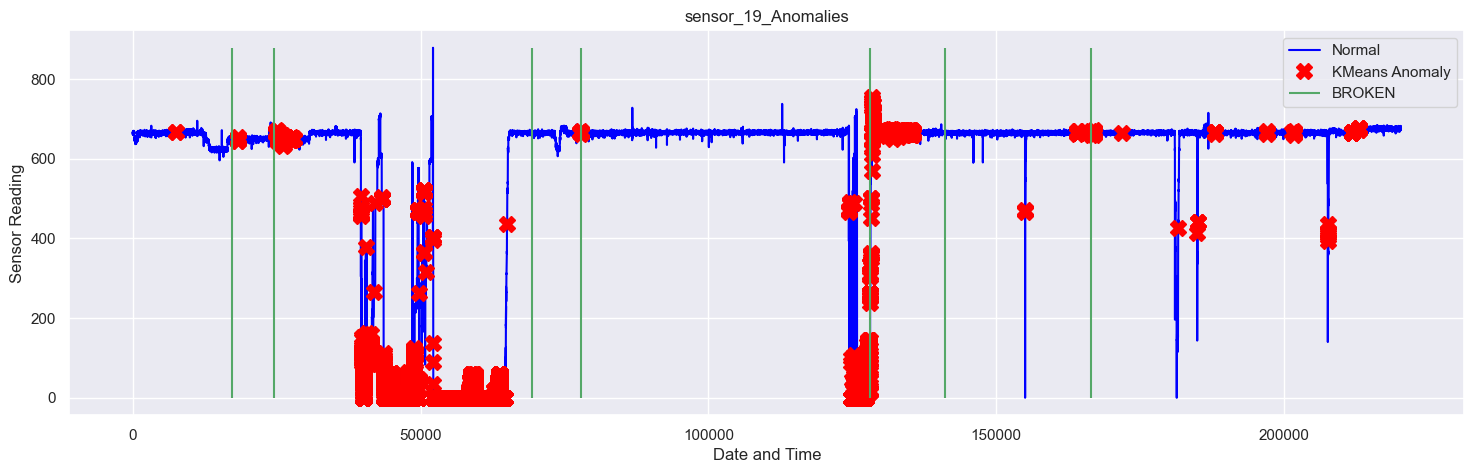

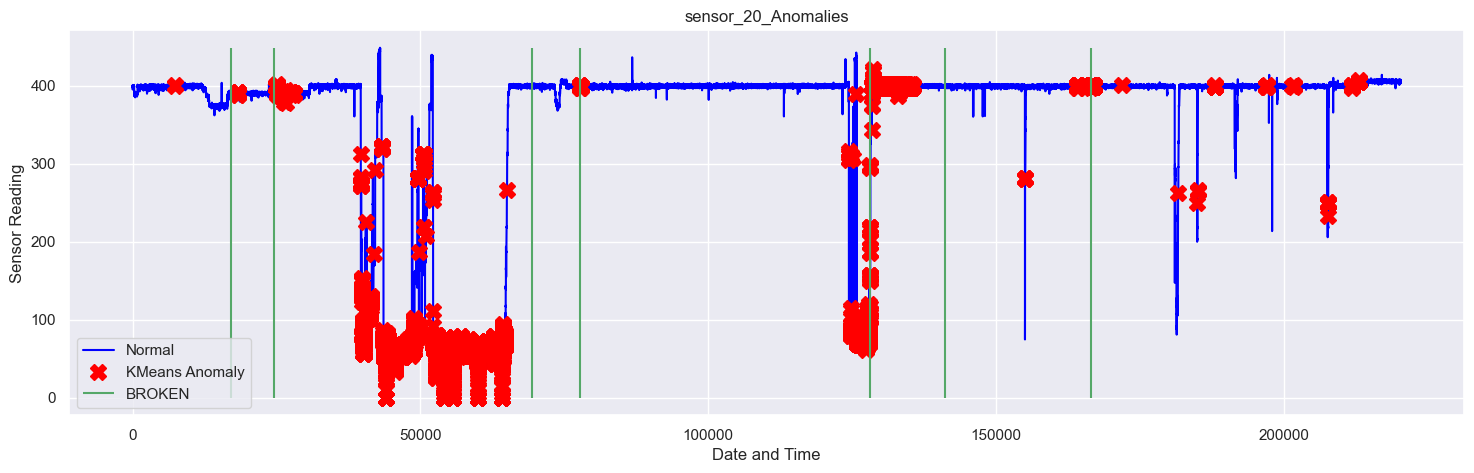

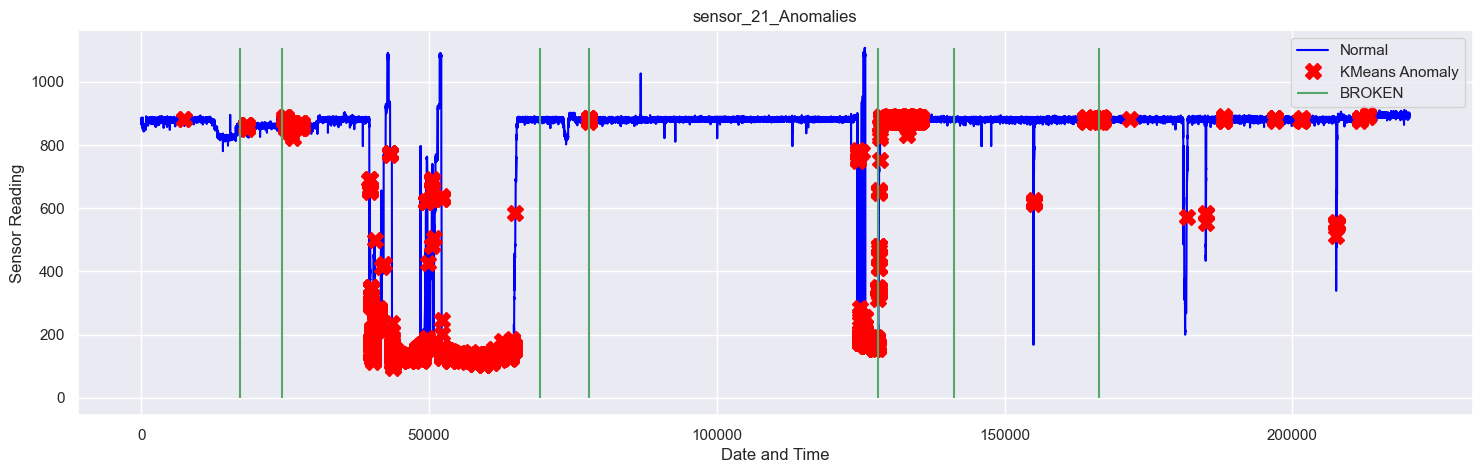

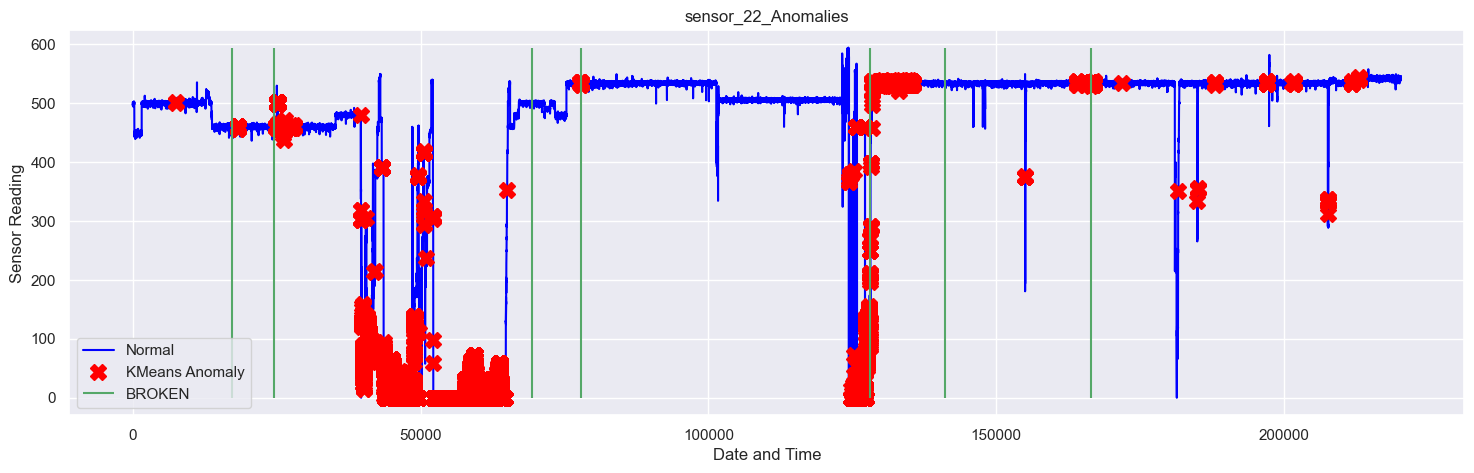

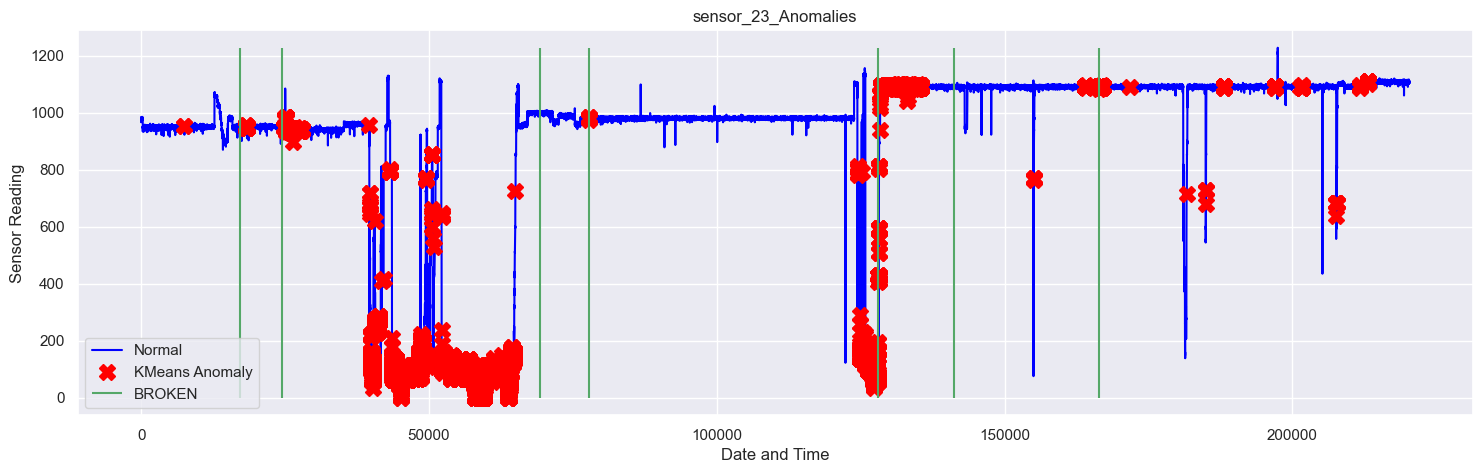

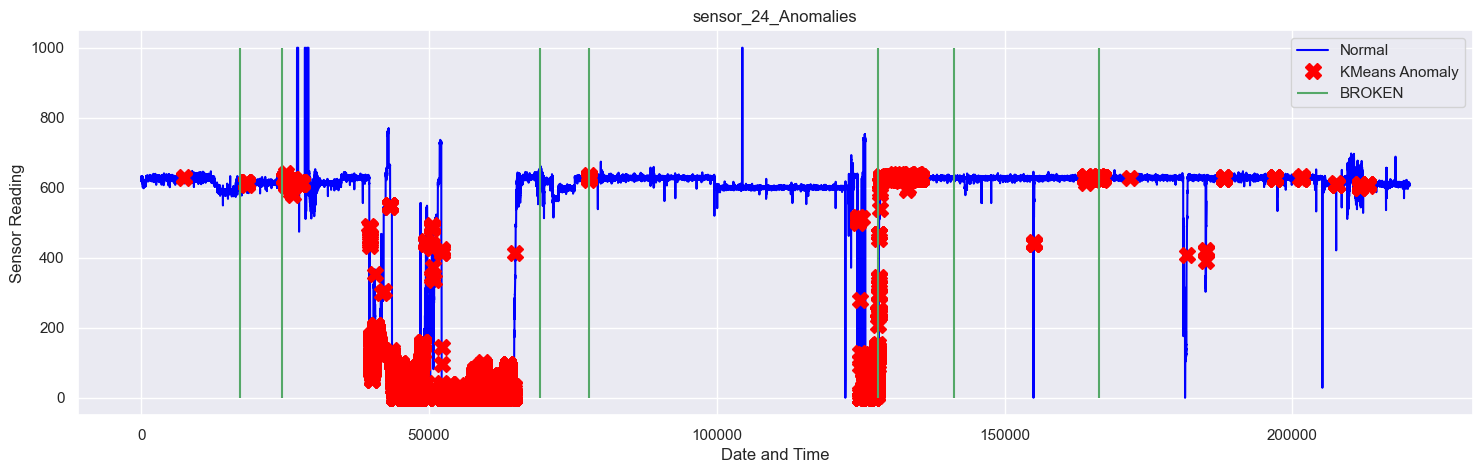

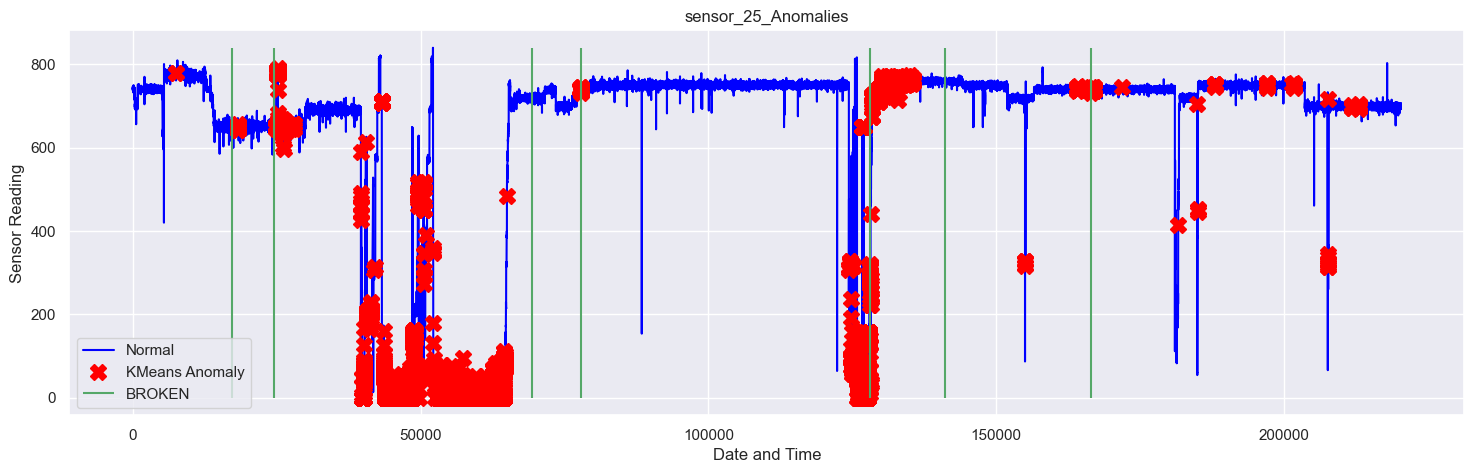

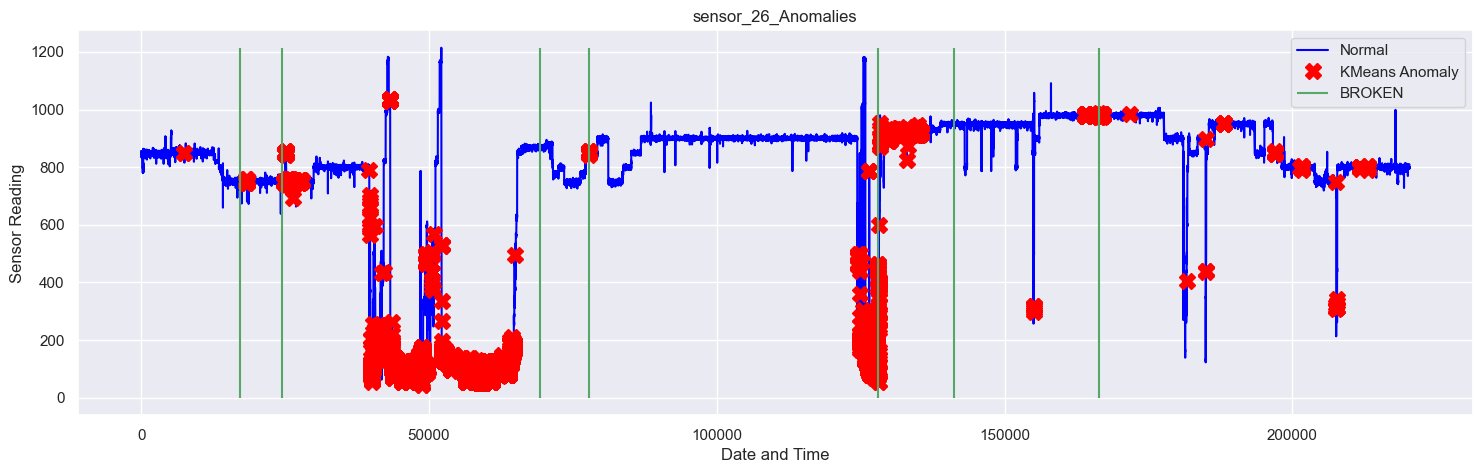

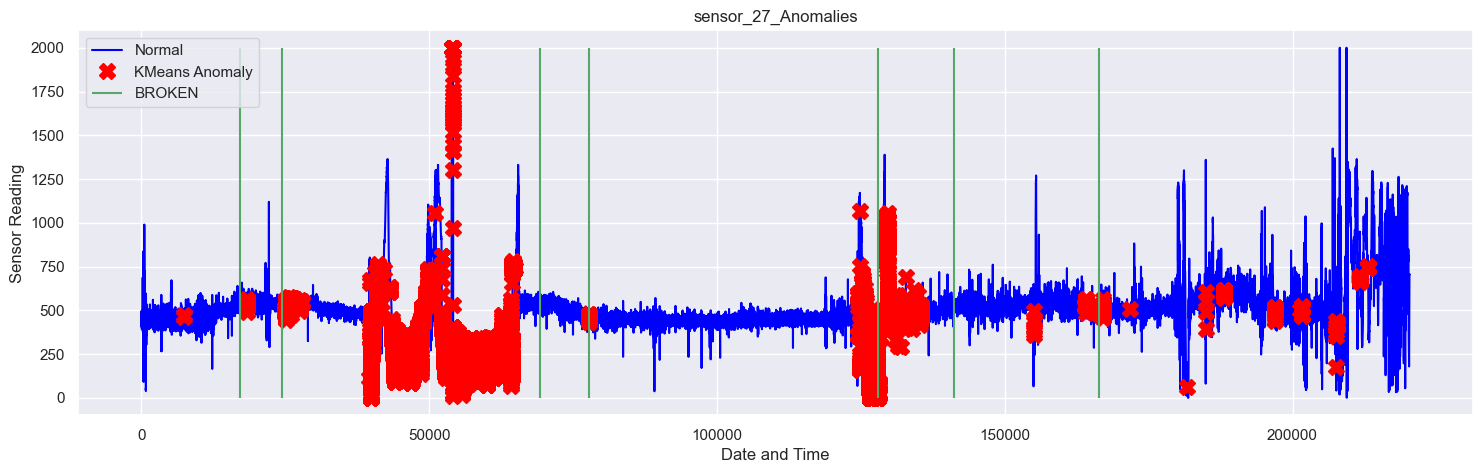

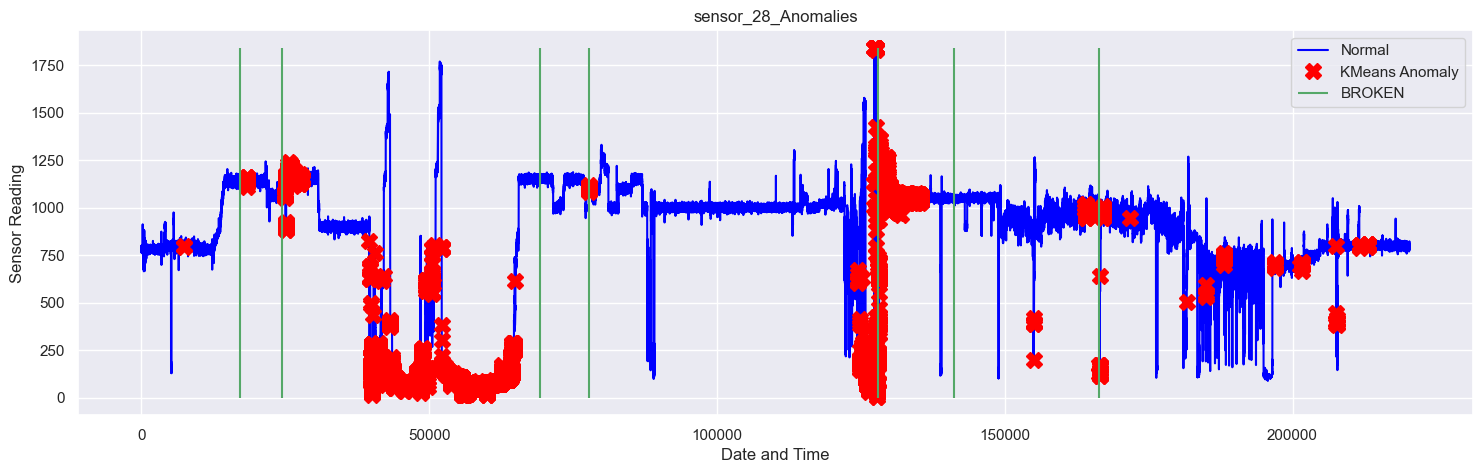

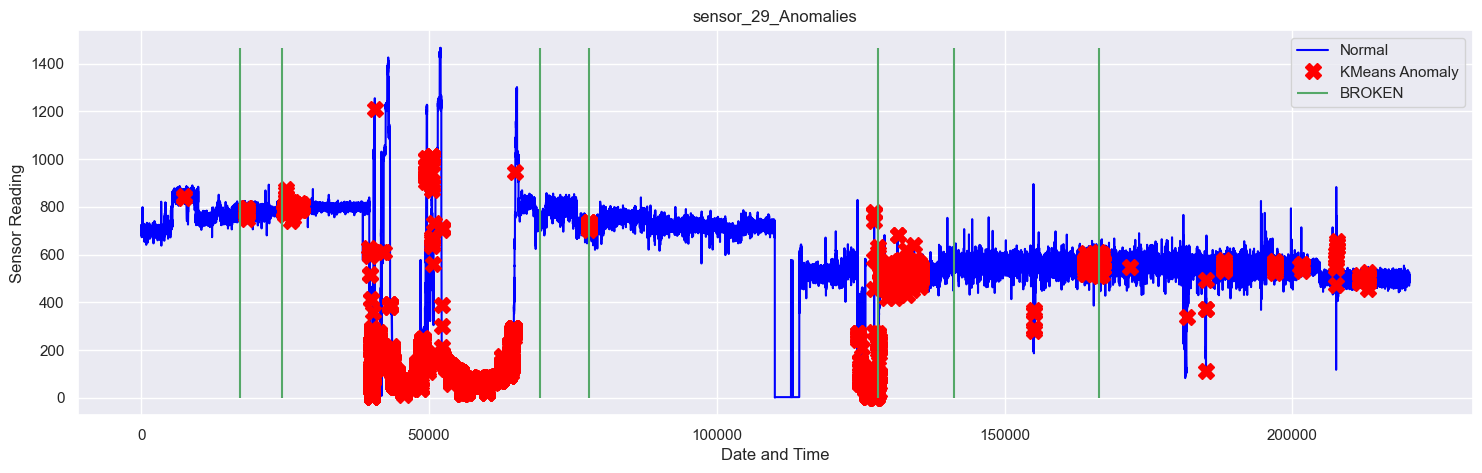

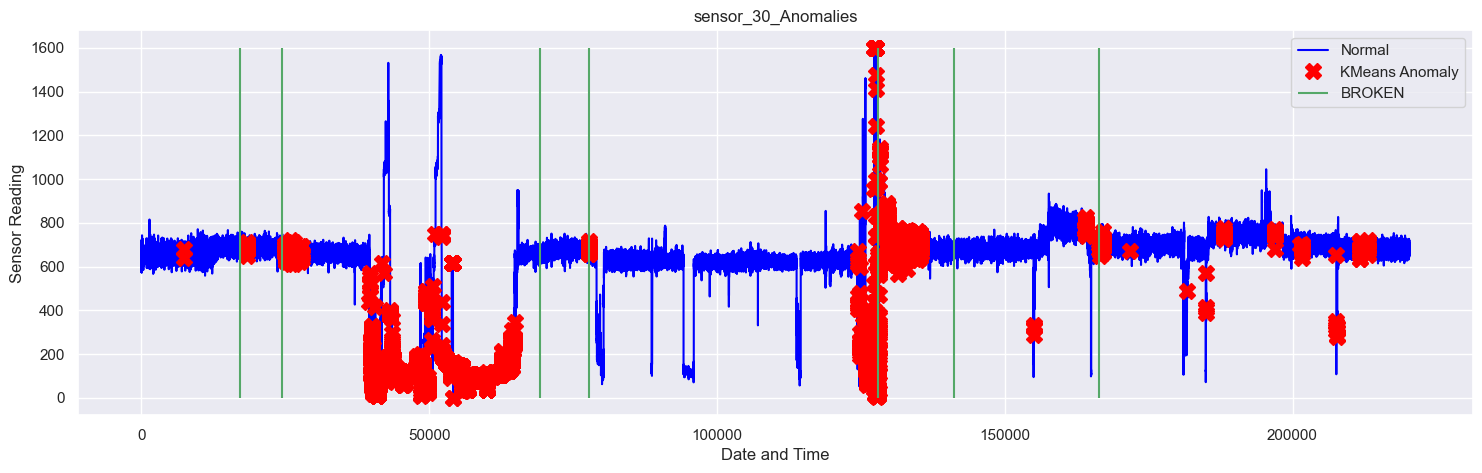

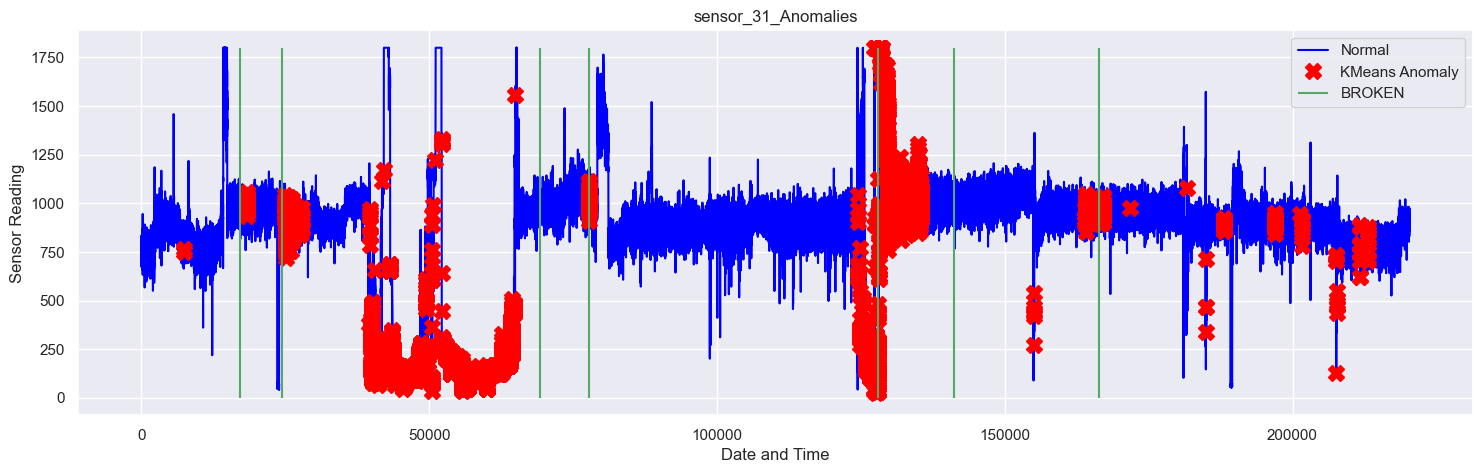

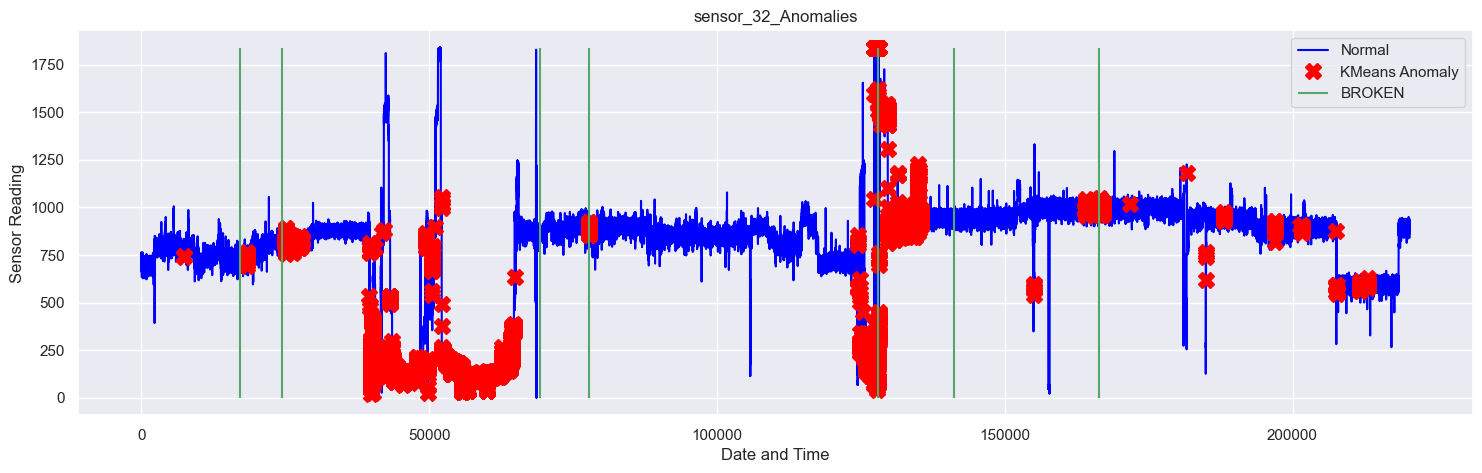

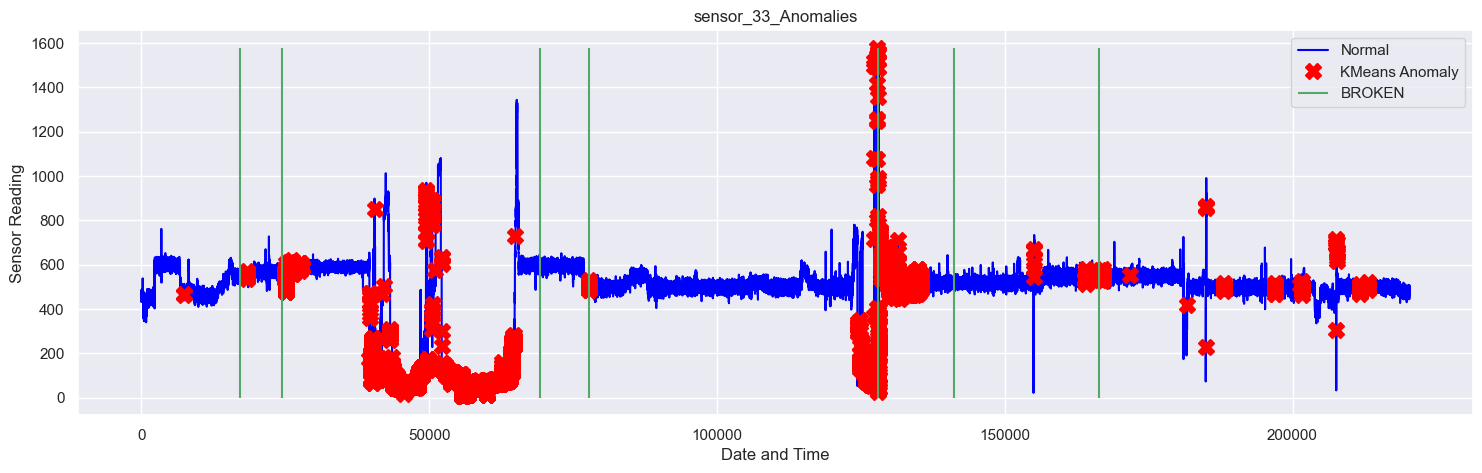

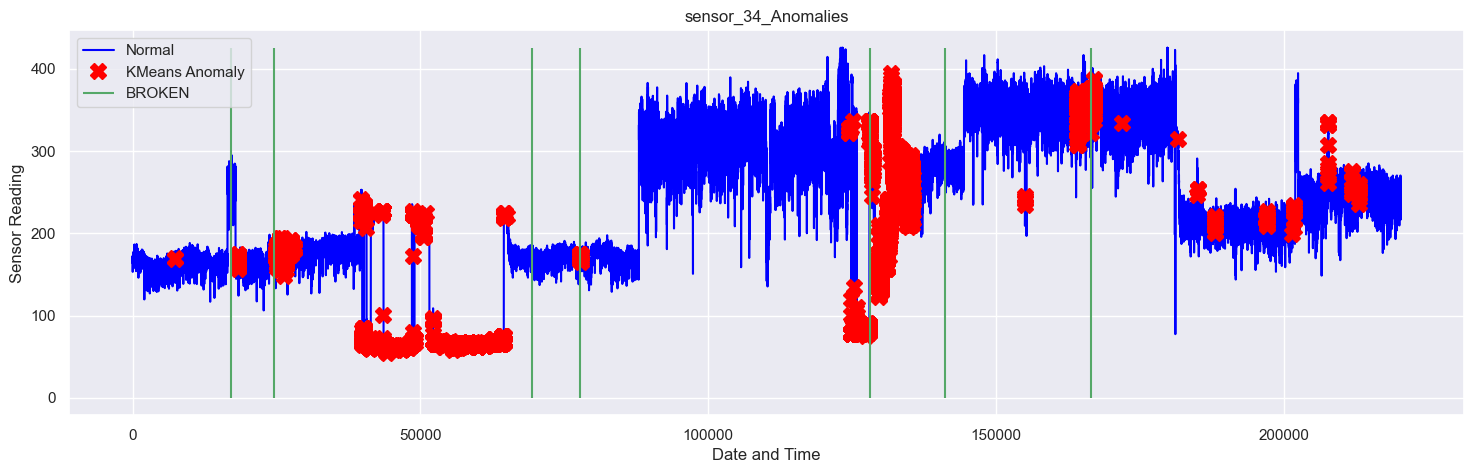

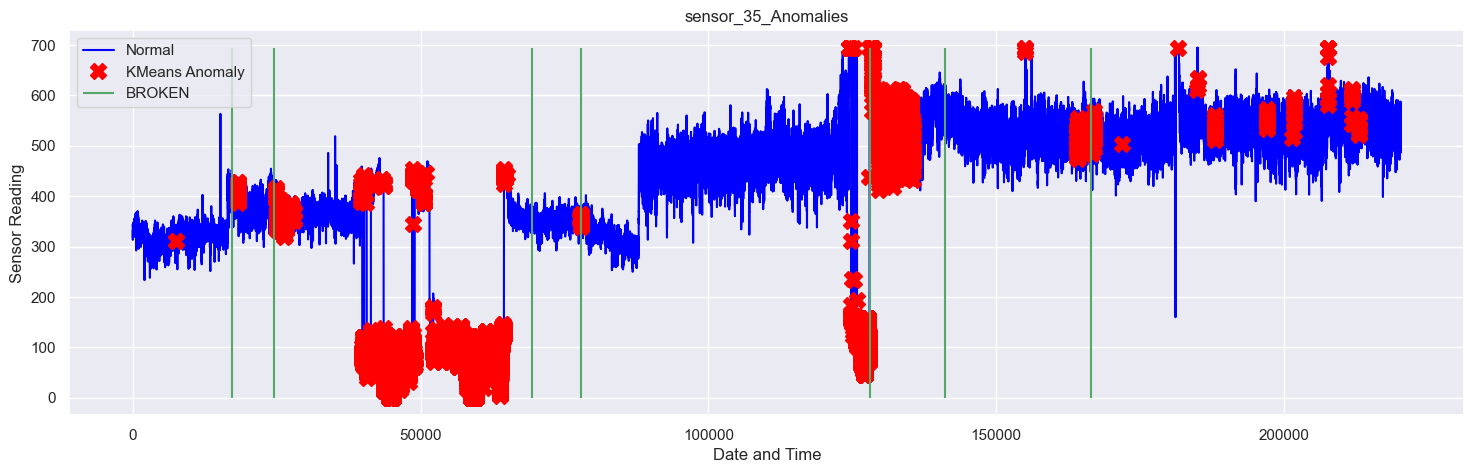

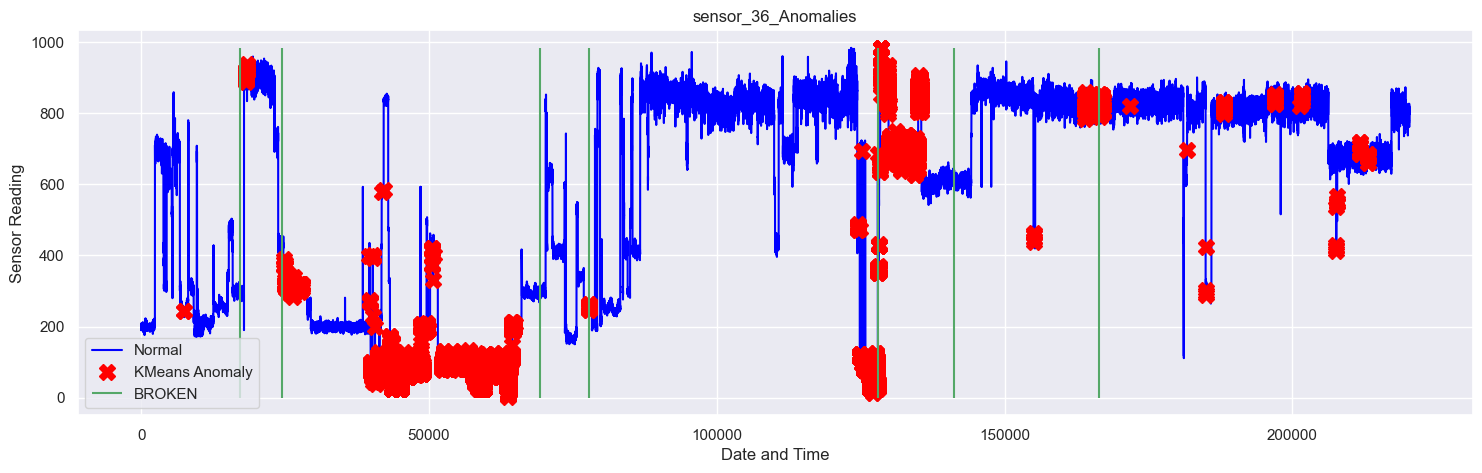

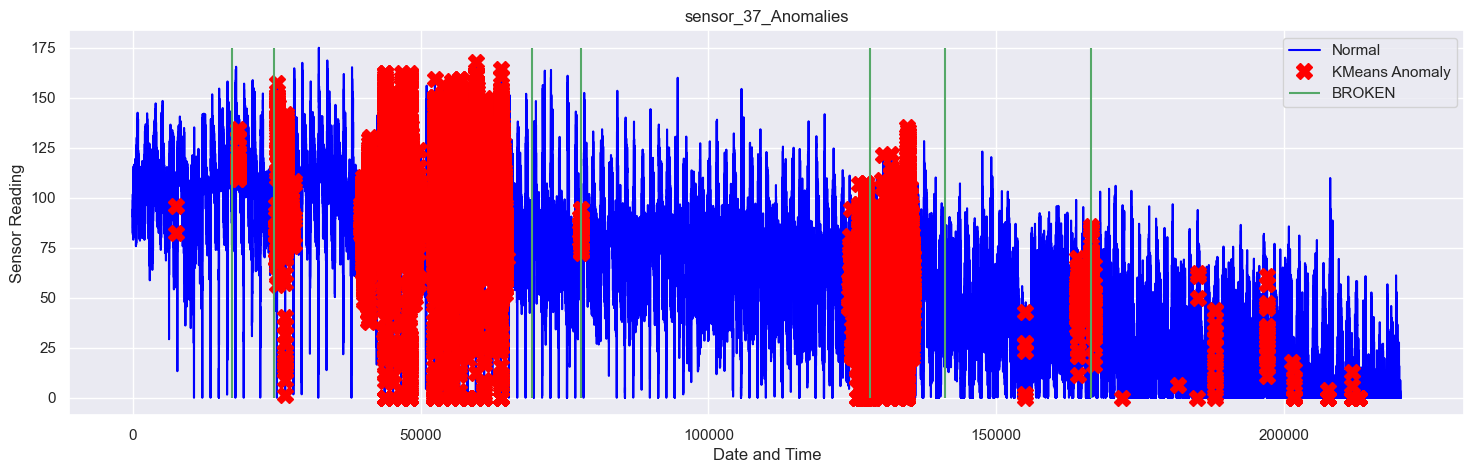

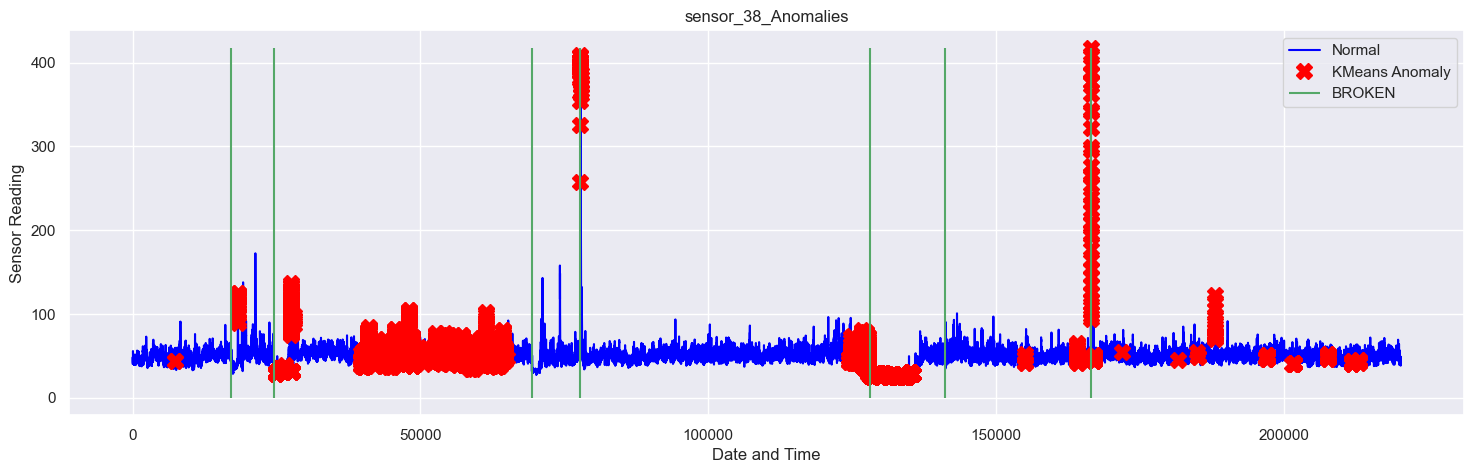

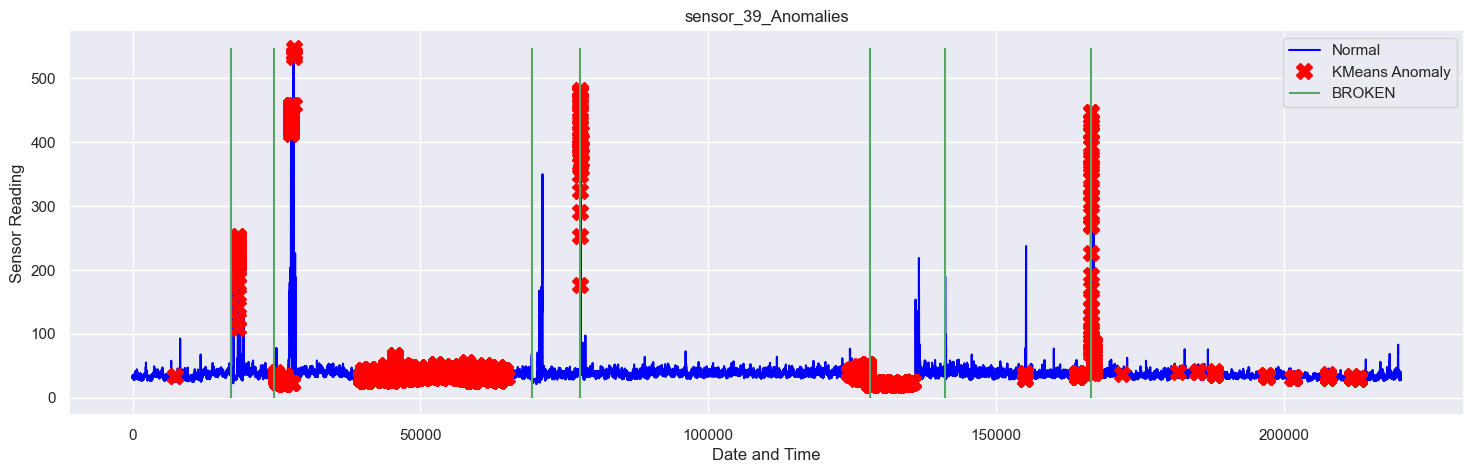

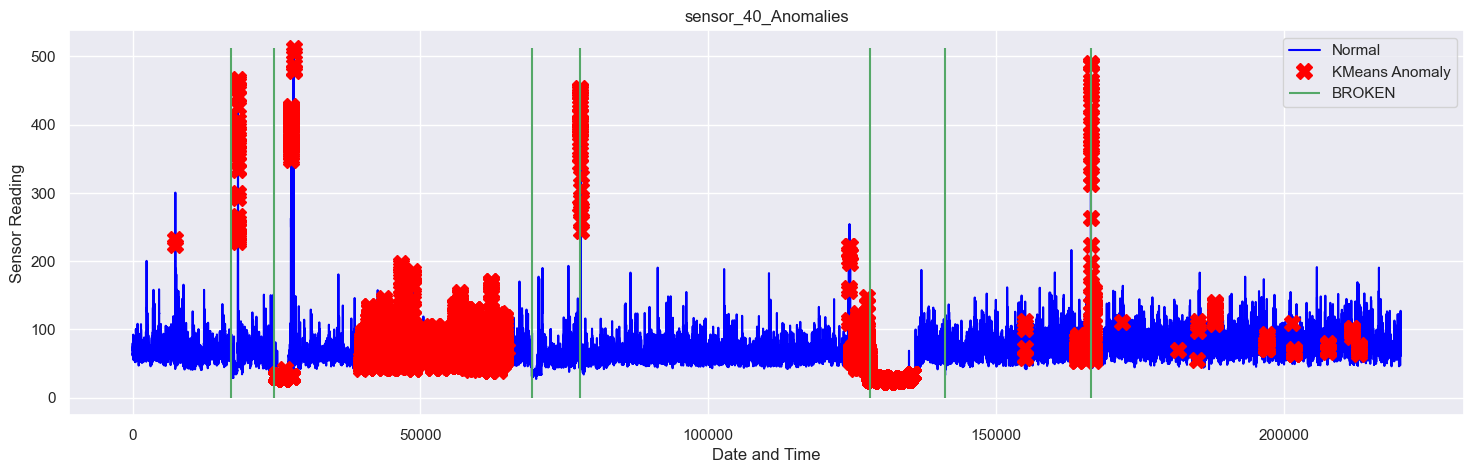

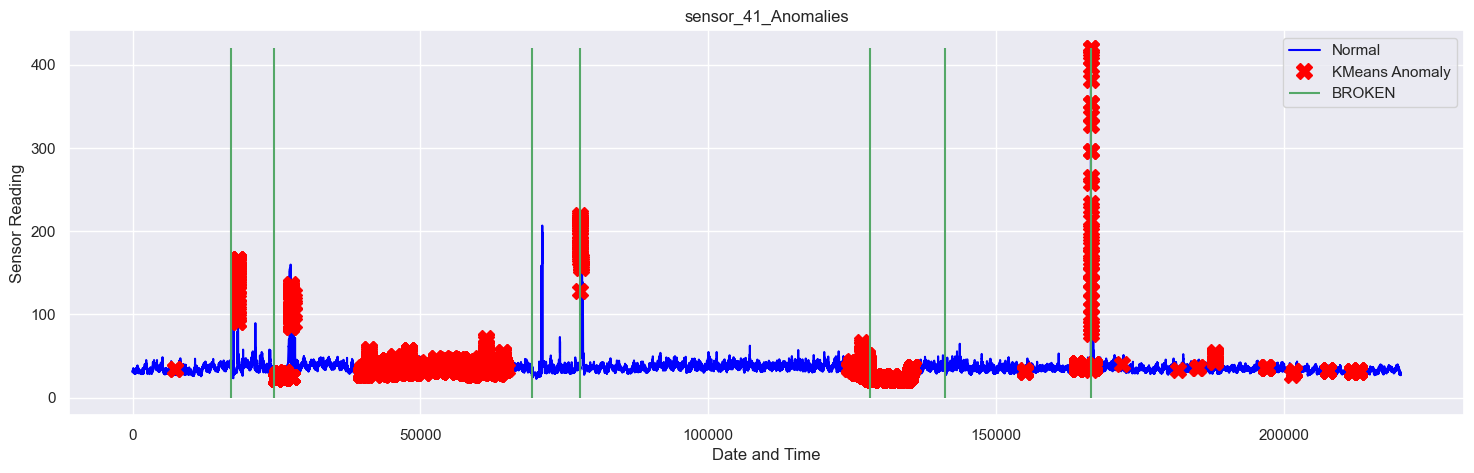

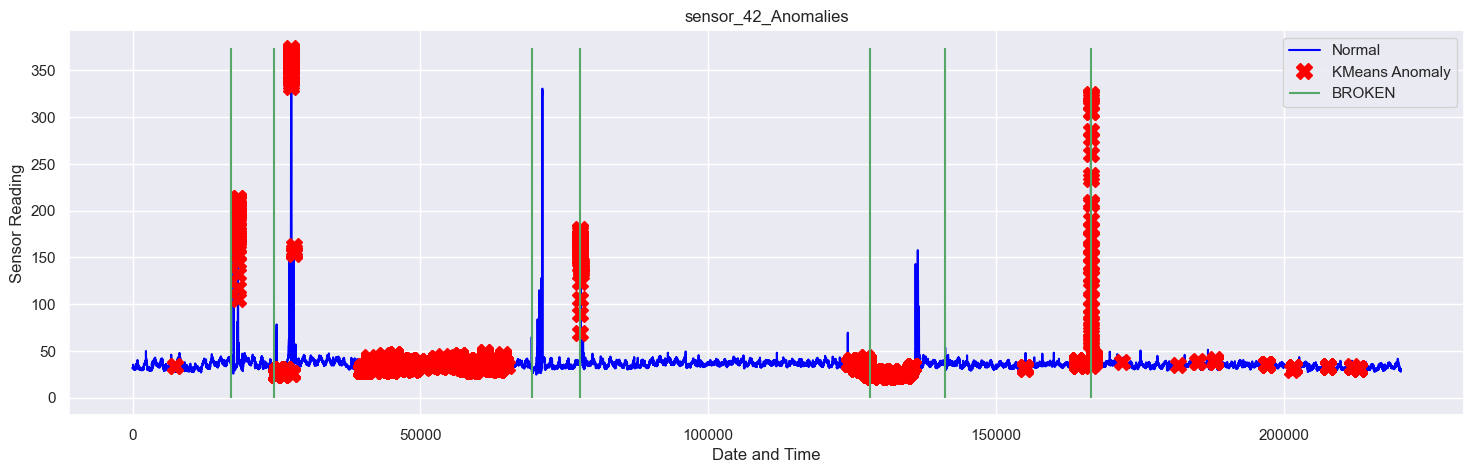

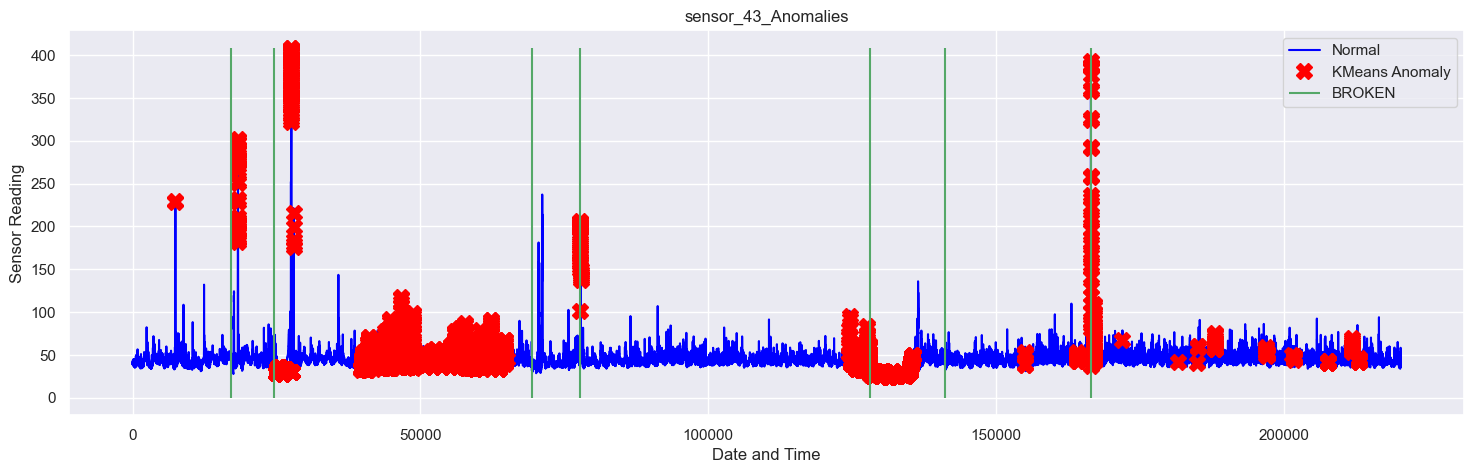

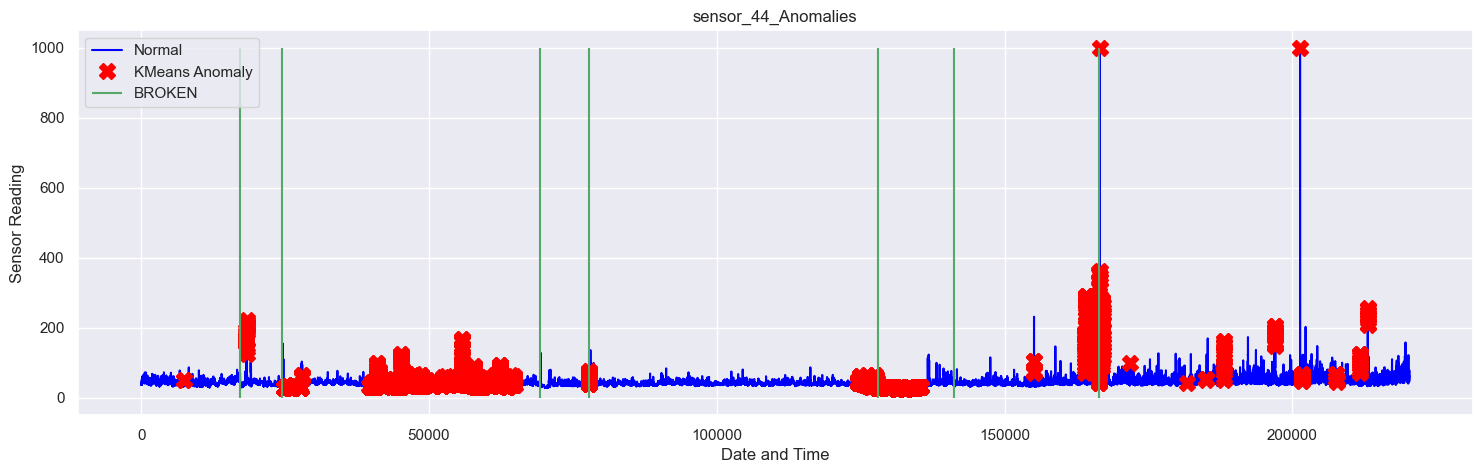

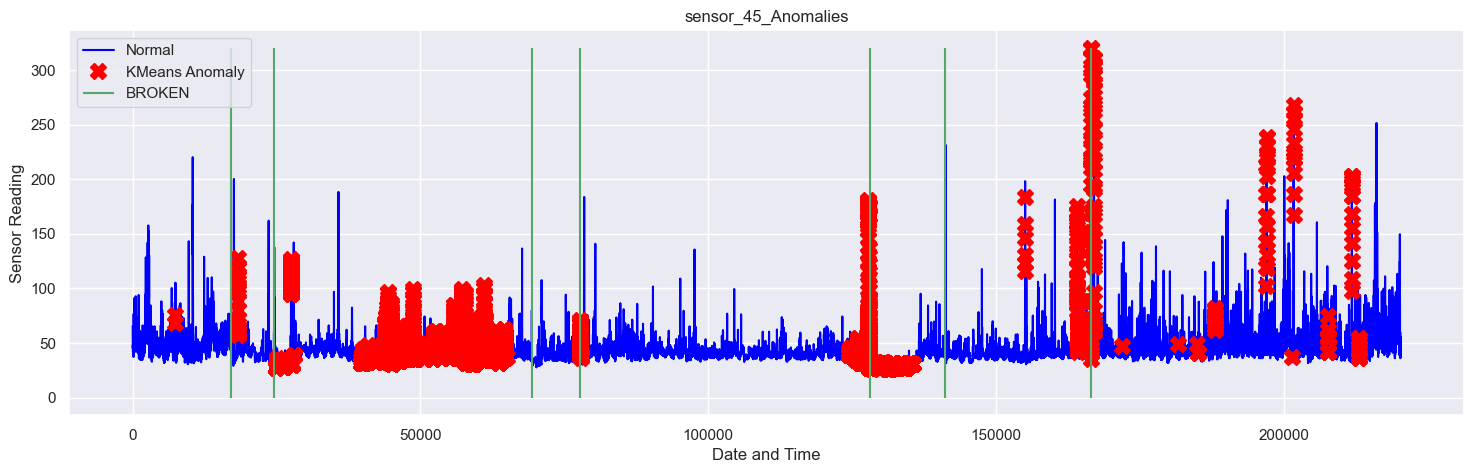

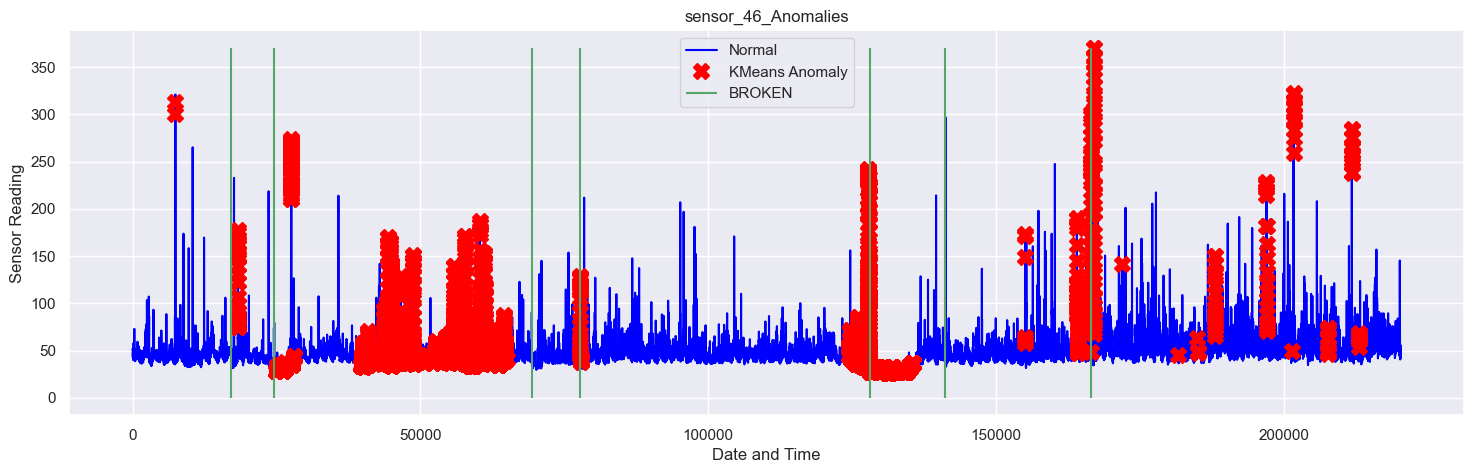

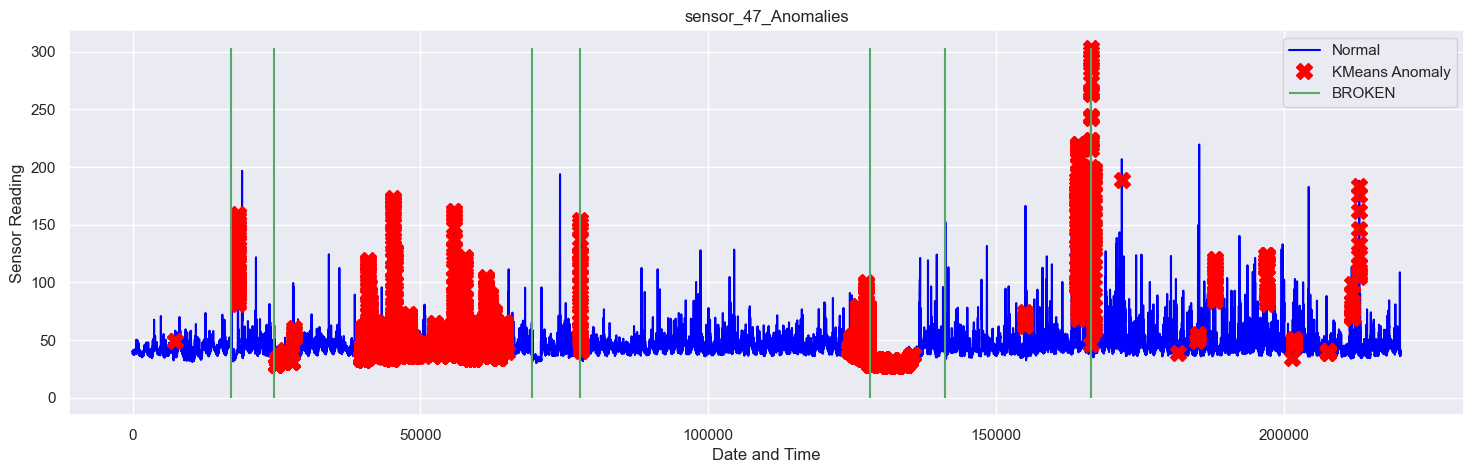

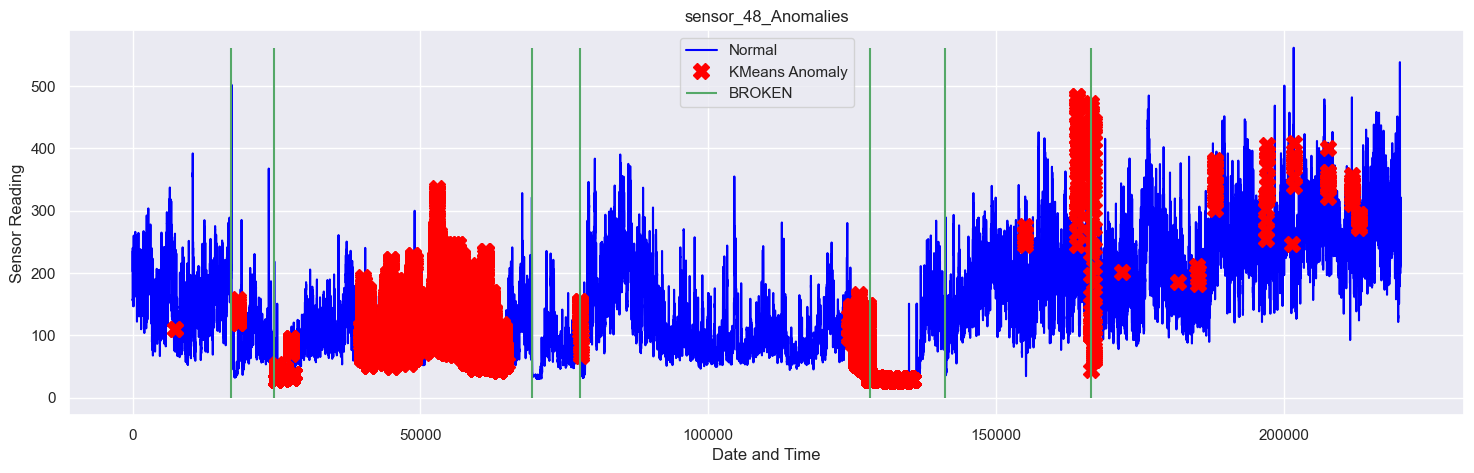

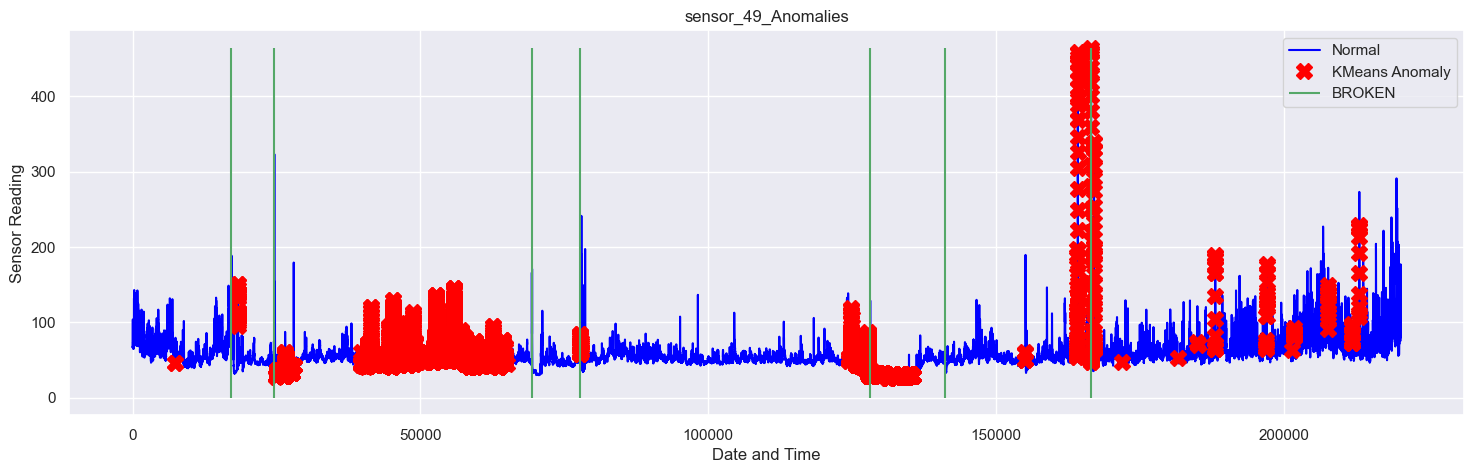

In [48]:
# Extract the readings from the BROKEN state of the pump
broken = pump_data[pump_data['machine_status']=='BROKEN']
pump_data['kmeans_anomaly'] = pd.Series(sensorsdf_red_pca_0p55['kmeans_anomaly'].values, 
                                                     index=pump_data.index)

a = pump_data[pump_data['kmeans_anomaly'] == 1] #anomaly
for name in pump_data.columns[1:-2]:
    _ = plt.figure(figsize=(18,5))
    _ = plt.plot(pump_data[name], color='blue', label='Normal')
    _ = plt.plot(a[name], linestyle='none', marker='X', color='red', markersize=12, label='KMeans Anomaly')
    _ = plt.vlines(broken.index,0,pump_data[name].max(), linestyle='solid', color='g',label= 'BROKEN')
    #_ = plt.plot(broken[name], linestyle='none', marker='X', color='g', markersize=12, label='BROKEN')
    _ = plt.xlabel('Date and Time')
    _ = plt.ylabel('Sensor Reading')
    _ = plt.title(str(name) + '_Anomalies')
    _ = plt.legend(loc='best')
    plt.show()
    

Summary:

It can be appreciated that Kmeans detects outliers mainly in the zones with spikes,
sometimes these match with the days the pumps are broken, but in a great number it also displays 
anomalies in zones with normal behaviour not associated with broken pumps.

## Isolation Forest

IF is an efficient algorithm for outlier detection on high dimensional data. The algo builds a RF in which each Decission Tree is grown randomly. Anomalies are usually far from other distances.

In [49]:
# fit and predict
model_if =  IsolationForest(random_state=13)

model_if.fit(sensorsdf_red_pca_0p55.drop('kmeans_anomaly', axis = 1)) 

sensorsdf_red_pca_0p55['if_anomaly'] = pd.Series(model_if.predict(sensorsdf_red_pca_0p55.drop('kmeans_anomaly', axis = 1)))

In [50]:
sensorsdf_red_pca_0p55.head()

pc1       pc2  kmeans_anomaly  if_anomaly
0 -0.052115  0.379152               0           1
1 -0.052115  0.379152               0           1
2 -0.192002  0.427891               0           1
3 -0.193824  0.406918               0           1
4 -0.149628  0.547579               0           1